In [31]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from typing import Dict
from scipy.stats import norm
from scipy.optimize import brentq

# 1. Data preprocessing

In [43]:
def clean_df(df_raw: pd.DataFrame, underlying, current_price, r, div_yield) -> pd.DataFrame:
    
    df_raw = pd.read_excel('20250131.xlsx', engine='openpyxl', header=None)
    df_valid = df_raw[df_raw[0].astype(str).str.startswith('SPXW')].copy()

    base_cols = ['ticker', 'K', 'bid', 'ask', 'last_price', 'iv', 'volume', 'open_interest', 
                 'delta', 'gamma', 'theta', 'vega', 'rho', 'T', 'xtype', 'thr_iv', 'thr_price']
    
    df_valid.columns = [col + '_call' for col in base_cols] + [col + '_put' for col in base_cols]
    
    call_df = df_valid[[col + '_call' for col in base_cols]].copy()
    put_df = df_valid[[col + '_put' for col in base_cols]].copy()
    
    call_df.columns = base_cols
    put_df.columns = base_cols
    
    call_df['cp_flag'] = 'C'
    put_df['cp_flag'] = 'P'
    
    options_df = pd.concat([call_df, put_df], axis=0, ignore_index=True)
    
    numeric_cols = ['K', 'bid', 'ask', 'last_price', 'iv', 'volume', 'open_interest',
                    'delta', 'gamma', 'theta', 'vega', 'rho', 'T', 'thr_iv', 'thr_price']
    
    options_df[numeric_cols] = options_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    options_df['xtype'] = options_df['xtype'].astype(str).str.strip()
    options_df['ticker'] = options_df['ticker'].astype(str).str.strip()
    options_df['S'] = current_price
    options_df['M'] = options_df['S'] / options_df['K']
    options_df['mid'] = (options_df['bid'] + options_df['ask']) / 2
    options_df['iv'] = options_df['iv'] / 100
    options_df['T'] = options_df['T'] / 365
    options_df['r'] = r
    options_df['q'] = div_yield
    options_df['thr_iv'] = options_df['thr_iv'] / 100
    options_df['iv'] = options_df['iv'].apply(lambda x: np.nan if pd.isna(x) or x == 0 else x)
    options_df['last_price'] = options_df['last_price'].apply(lambda x: np.nan if pd.isna(x) or x == 0 else x)
    options_df['volume'] = options_df['volume'].apply(lambda x: np.nan if pd.isna(x) or x == 0 else x)
    options_df['intrinsic_value'] = 0.0
    options_df.loc[options_df['cp_flag'] == 'C', 'intrinsic_value'] = (options_df['S'] - options_df['K']).clip(lower=0)
    options_df.loc[options_df['cp_flag'] == 'P', 'intrinsic_value'] = (options_df['K'] - options_df['S']).clip(lower=0)
    
    return options_df

def format_option_df(df: pd.DataFrame, vol_col: str, min_m: float = 0.8, max_m: float = 1.5) -> Dict[str: pd.DataFrame, str: pd.DataFrame]:
    
    df['d1'] = (np.log(df['S'] / df['K']) + (df['r'] + 0.5 * df[vol_col] ** 2) * df['T']) / (df[vol_col] * np.sqrt(df['T']))
    df['d2'] = df['d1'] - df[vol_col] * np.sqrt(df['T'])
    
    call_df = df[(df['cp_flag'] == 'C') & (df['M'] > min_m) & (df['M'] < max_m)].copy()
    put_df = df[(df['cp_flag'] == 'P') & (df['M'] > min_m) & (df['M'] < max_m)].copy()
    
    call_df['bs_price'] = (
        call_df['S'] * np.exp(-call_df['q'] * call_df['T']) * norm.cdf(call_df['d1']) -
        call_df['K'] * np.exp(-call_df['r'] * call_df['T']) * norm.cdf(call_df['d2'])
    )
    put_df['bs_price'] = (
        put_df['K'] * np.exp(-put_df['r'] * put_df['T']) * norm.cdf(-put_df['d2']) -
        put_df['S'] * np.exp(-put_df['q'] * put_df['T']) * norm.cdf(-put_df['d1'])
    )

    call_df['mid_diff'] = (call_df['bs_price'] - call_df['mid']) / call_df['mid']
    put_df['mid_diff'] = (put_df['bs_price'] - put_df['mid']) / put_df['mid']
    call_df['last_diff'] = (call_df['bs_price'] - call_df['last_price']) / call_df['last_price']
    put_df['last_diff'] = (put_df['bs_price'] - put_df['last_price']) / put_df['last_price']
    call_df['thr_diff'] = (call_df['bs_price'] - call_df['thr_price']) / call_df['thr_price']
    put_df['thr_diff'] = (put_df['bs_price'] - put_df['thr_price']) / put_df['thr_price']
      
    return {"call": call_df, "put": put_df}

underlying = 'SPXW'
date = '2025-01-31'
current_price = 5974.07
interest = 0.04597907
div_yield = 0.01025257
raw_df = pd.read_excel('20250131.xlsx', engine='openpyxl', header=None)
option_df = clean_df(raw_df, underlying, current_price, interest, div_yield)
formatted = format_option_df(option_df, vol_col='iv')
call_df = formatted['call']
put_df = formatted['put']

# What kind of price that I need to use for my analysis?

,bs_price,ask,bid,mid,volume,last_price,thr_price,mid_diff,last_diff,thr_diff
24,1987.407205,1997.199951,1992.500000,1994.849976,1.0,1945.010010,1996.596123,-0.003731,0.021798,-0.004602
25,1938.162924,1952.699951,1935.400024,1944.049988,NaN,NaN,1946.929666,-0.003028,NaN,-0.004503
26,NaN,1903.099976,1885.900024,1894.500000,NaN,1948.030029,1897.267083,NaN,NaN,NaN
27,NaN,1853.500000,1836.300049,1844.900024,NaN,1425.099976,1847.608910,NaN,NaN,NaN
28,NaN,1803.900024,1787.000000,1795.450012,NaN,1732.890015,1797.955827,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
410,0.196711,0.250000,0.100000,0.175000,NaN,0.250000,0.628562,0.124061,-0.213158,-0.687047
411,0.278768,0.250000,0.000000,0.125000,NaN,0.350000,0.592058,1.230146,-0.203519,-0.529154
412,0.279773,0.250000,0.000000,0.125000,3.0,0.150000,0.557767,1.238185,0.865154,-0.498405
413,0.281965,0.250000,0.000000,0.125000,NaN,NaN,0.525527,1.255724,NaN,-0.463461


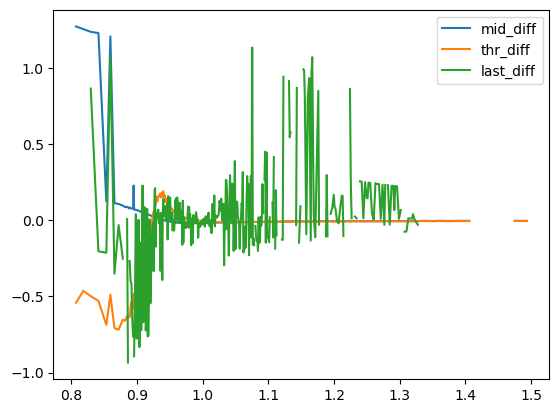

In [44]:
display(call_df[['bs_price', 'ask', 'bid', 'mid', 'volume', 'last_price', 'thr_price', 'mid_diff', 'last_diff', 'thr_diff', ]])
plt.plot(call_df['M'], call_df[['mid_diff', 'thr_diff', 'last_diff']], label=('mid_diff', 'thr_diff', 'last_diff'))
plt.legend()
plt.show()

In [24]:
display(put_df[['bs_price', 'ask', 'bid', 'mid', 'volume', 'last_price', 'thr_price', 'mid_diff', 'last_diff', 'thr_diff', ]])

,bs_price,ask,bid,mid,volume,last_price,thr_price,mid_diff,last_diff,thr_diff
443,2.347164,2.450000,2.150000,2.300000,54.0,2.520000,1.982216,0.020506,-0.068586,0.184111
444,2.461154,2.550000,2.250000,2.400000,10.0,2.400000,2.081770,0.025481,0.025481,0.182241
445,2.579393,2.650000,2.350000,2.500000,2.0,2.850000,2.185199,0.031757,-0.094950,0.180392
446,2.702482,2.800000,2.500000,2.650000,2.0,3.000000,2.293037,0.019804,-0.099173,0.178560
447,2.831186,2.900000,2.600000,2.750000,8.0,3.100000,2.405967,0.029522,-0.086714,0.176735
...,...,...,...,...,...,...,...,...,...,...
829,998.909801,1000.500000,982.000000,991.250000,NaN,902.900024,991.975364,0.007727,0.106335,0.006991
830,1098.385520,1099.900024,1082.099976,1091.000000,NaN,NaN,1091.470884,0.006769,NaN,0.006335
831,1197.862635,1199.300049,1180.599976,1189.950012,NaN,1132.420044,1190.968617,0.006650,0.057790,0.005789
832,1297.341180,1298.699951,1280.099976,1289.399963,NaN,NaN,1290.468400,0.006159,NaN,0.005326


In [109]:
def bs_call(S: float, K: float, T: float, r: float, q: float, iv: float) -> float:
    d1 = (np.log(S/K) + (r - q + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_put(S: float, K: float, T: float, r: float, q: float, iv: float) -> float:
    d1 = (np.log(S/K) + (r - q + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def find_imvol_brentq(mkt: float, S: float, K: float, T: float, r: float, q: float, cp_flag: str) -> float: 
    def obj(iv: float):
        price = bs_call(S, K, T, r, q, iv) if cp_flag == 'C' else bs_put(S, K, T, r, q, iv)
        return price - mkt

    try:
        return brentq(obj, 1e-8, 3.0, maxiter = 1000)
    except (ValueError, RuntimeError):
        return np.nan

def test_imvol(mkt: float, S: float, K: float, T: float, r: float, q: float, iv: float, cp_flag: str) -> bool:
    if np.isnan(mkt):
        return True
    price = bs_call(S, K, T, r, q, iv) if cp_flag == 'C' else bs_put(S, K, T, r, q, iv)
    return abs(price - mkt) < 1e-8

def find_imvol(mkt: float, label: str, S: float, K: float, T: float, r: float, q: float, cp_flag: str, idx: int) -> float:
    iv = find_imvol_brentq(mkt, S, K, T, r, q, cp_flag)
    # TODO: if brentq failed, try Newton-Raphson
    bs_price = bs_call(S, K, T, r, q, iv) if cp_flag == 'C' else bs_put(S, K, T, r, q, iv)
    if test_imvol(mkt, S, K, T, r, q, iv, cp_flag):
        return iv
    else:
        raise ValueError(
            f"[{label}] Implied vol inverstion, test failed @ index {idx}:\n"
            f"  Market: {mkt:.4f}, BS Price: {bs_price:.4f}\n"
            f"  IV: {iv:.6f}, S: {S}, K: {K}, T: {T}, r: {r}, q: {q}"
        )

def add_implied_vol(df: pd.DataFrame, cp_flag: str) -> pd.DataFrame:
    price_lower_bound = []
    bid_iv = []
    ask_iv = []
    mid_iv = []
    last_iv = []
    thr_iv = []

    for idx, row in df.iterrows():
        S = row['S']
        K = row['K']
        T = row['T']
        r = row['r']
        q = row['q']
        bid = row['bid']
        ask = row['ask']
        mid = row['mid']
        vol = row['volume']
        last_price = row['last_price']
        thr_price = row['thr_price']

        # Lower bound price

        plb = bs_call(S, K, T, r, q, iv=1e-8) if cp_flag == 'C' else bs_put(S, K, T, r, q, iv=1e-8)
        price_lower_bound.append(plb)

        # Apply safe implied vol lookup with validation
        bid_iv.append(np.nan if bid < plb else find_imvol(bid, 'BID', S, K, T, r, q, cp_flag, idx))
        ask_iv.append(np.nan if ask < plb else find_imvol(ask, 'ASK', S, K, T, r, q, cp_flag, idx))
        mid_iv.append(np.nan if mid < plb else find_imvol(mid, 'MID', S, K, T, r, q, cp_flag, idx))
        last_iv.append(np.nan if last_price < plb else find_imvol(last_price, 'LAST PRICE', S, K, T, r, q, cp_flag, idx))
        thr_iv.append(np.nan if thr_price < plb else find_imvol(thr_price, 'THEORETICAL', S, K, T, r, q, cp_flag, idx))

    df['iv_bid'] = bid_iv
    df['iv_ask'] = ask_iv
    df['iv_mid'] = mid_iv
    df['iv_last_price'] = last_iv
    df['iv_thr_price'] = thr_iv
    df['plb'] = price_lower_bound

    return df

call_df = add_implied_vol(call_df, cp_flag='C')
put_df = add_implied_vol(put_df, cp_flag='P')

call_df.to_csv('call_20250131.csv', index=False)
put_df.to_csv('put_20250131.csv', index=False)

In [65]:
call_df[['M', 'bid_iv']]

,M,bid_iv
24,1.493517,5.805595e-01
25,1.475079,NaN
26,1.457090,NaN
27,1.439535,NaN
28,1.422398,NaN
...,...,...
410,0.853439,1.547031e-01
411,0.841418,1.000000e-08
412,0.829732,1.000000e-08
413,0.818366,1.000000e-08


In [111]:
def plot_option_data(df, title_prefix="Call"):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True,
                                        gridspec_kw={'height_ratios': [2, 1, 1]})

    # --- Plot 1: Implied Volatility Scatter ---
    iv_labels = ['iv_bid', 'iv_ask', 'iv_mid', 'iv_last_price', 'iv_thr_price', 'thr_iv']
    for label in iv_labels:
        ax1.scatter(df['M'], df[label], label=label, marker='x', alpha=0.7)
    ax1.set_ylabel("Implied Volatility")
    ax1.set_title(f"{title_prefix} - IV vs Moneyness")
    ax1.legend()
    ax1.grid(True)

    # --- Plot 2: Bid-Ask Price Spread Line ---
    spread = df['ask'] - df['bid']
    ax2.plot(df['M'], spread, label='Bid-Ask Spread', color='gray', alpha=0.7)
    ax2.set_ylabel("Price Spread")
    ax2.set_title(f"{title_prefix} - Bid-Ask Spread")
    ax2.legend()
    ax2.grid(True)

    # --- Plot 3: Volume Bar Plot (log-scaled) ---
    volume_log = np.log10(df['volume'] + 1)  # add 1 to avoid log(0)
    ax3.bar(df['M'], volume_log, color='orange', alpha=0.7, label='Volume', width=0.001)
    ax3.set_xlabel("Moneyness (M)")
    ax3.set_ylabel("log(Volume + 1)")
    ax3.set_title(f"{title_prefix} - Volume vs Moneyness (Log Scale)")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

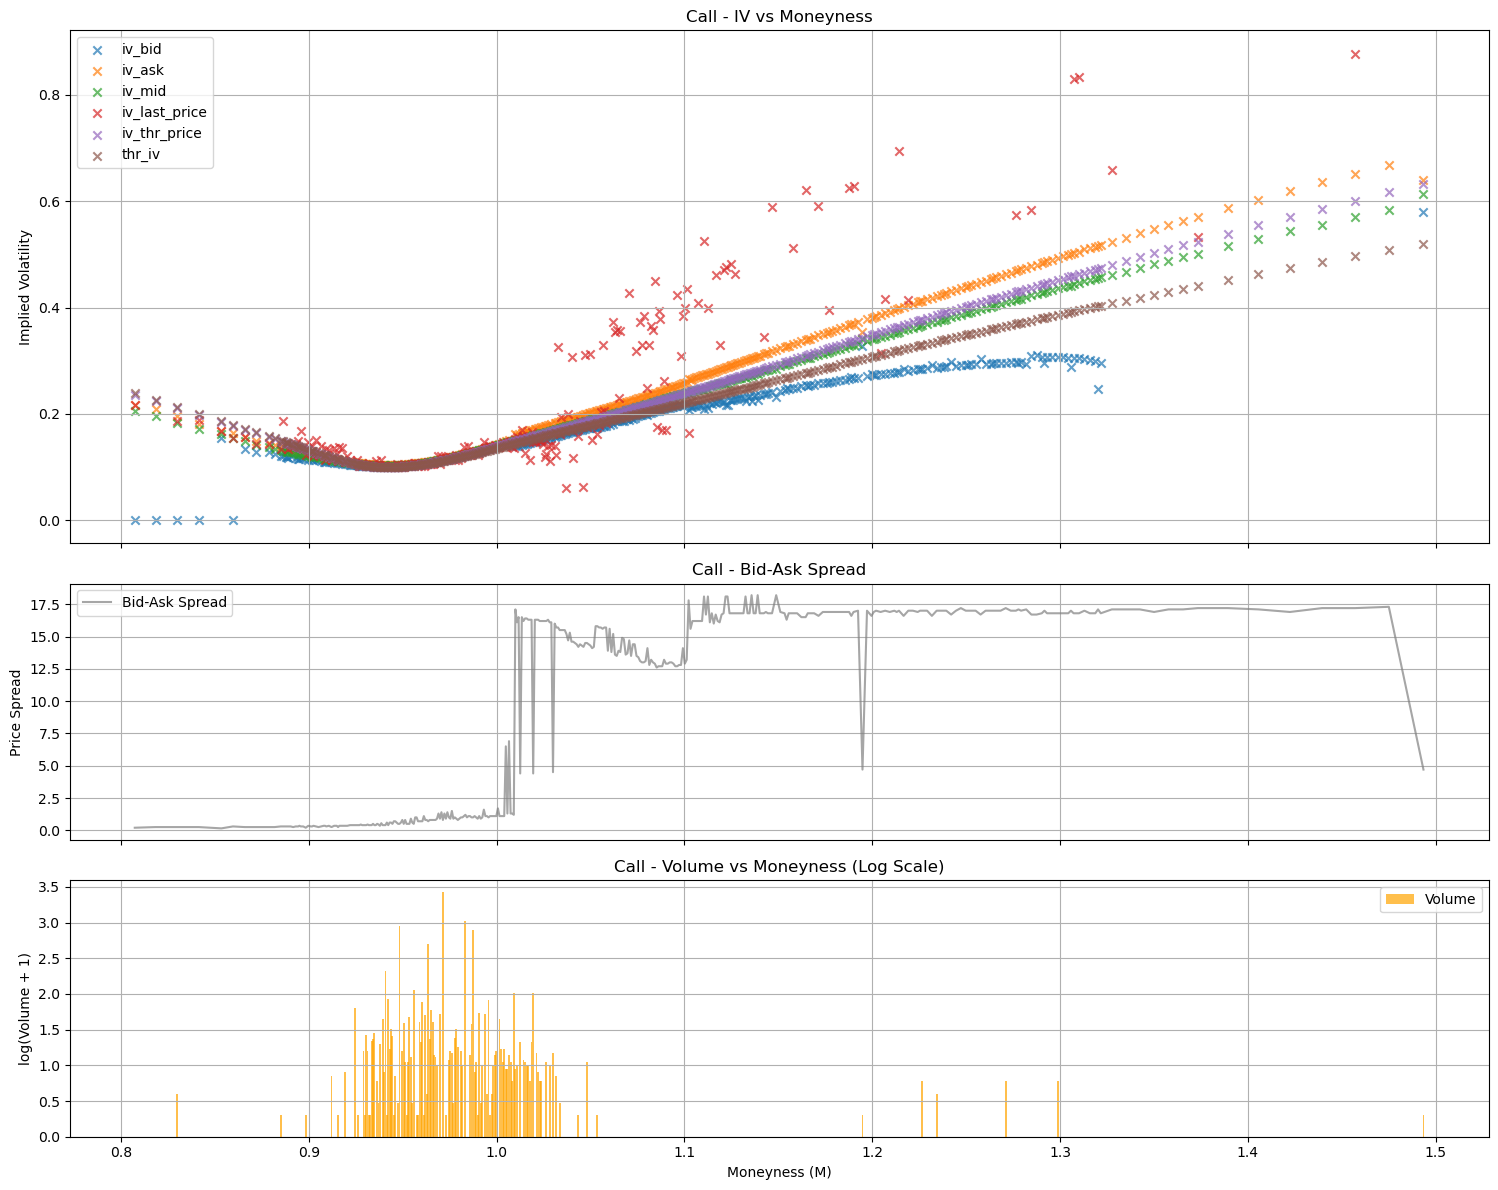

In [113]:
plot_option_data(call_df, title_prefix="Call")

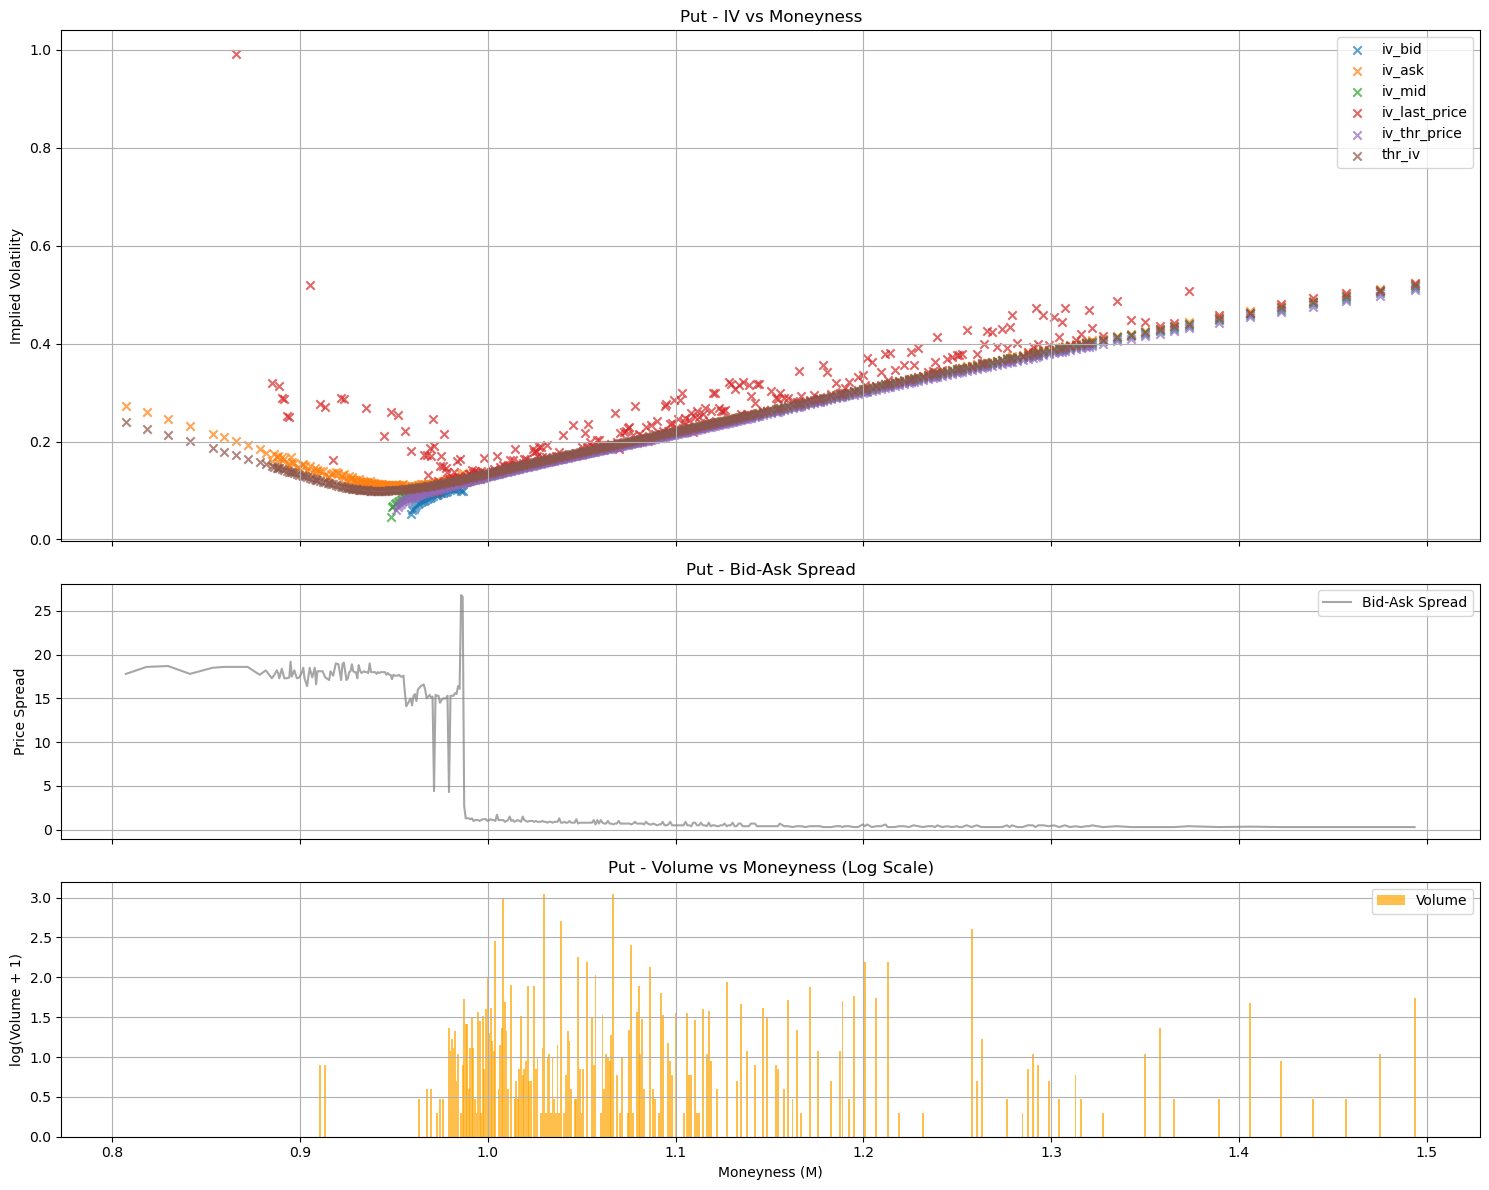

In [112]:
plot_option_data(put_df, title_prefix="Put")

In [105]:
put_df[['M', 'mid', 'plb', 'iv_mid', 'iv_thr_price']].tail()

,M,mid,plb,iv_mid,iv_thr_price
829,0.853439,991.250000,998.216507,NaN,NaN
830,0.841418,1091.000000,1097.727331,NaN,NaN
831,0.829732,1189.950012,1197.238155,NaN,NaN
832,0.818366,1289.399963,1296.748979,NaN,NaN
833,0.807307,1389.200012,1396.259803,NaN,NaN


# Risk-neutral probability distribution

### Methodology for Estimating Market Probability Density Functions 

#### Steps
1. (data source) Collected daily S&P 500 option data (SPX) across all strike prices traded (volume > 0) that expire approximately a month later from Bloomberg. This is both an index and European style option.
2. (day count convention) Used Act/365 day count convention so that the time to maturity is the remaining days up to the maturity over 365
3. (interest rate) Associated a risk-free rate with each option based on an interpolation of the risk-free yield curve from Bloomberg that existed on the specific price date. I used a convex monotone interpolation method to match the time to expiration of each option and express each value as a continuously compounded interest rate. 
4. (dividend yield) implied dividend yield curve? DIVD 
5. (put data) all put options are transformed into call option prices using the put-call parity $C=P+Se^{-q*\tau}-Ke^{-r*\tau}$ where q and r is continuously compounded dividend yield and interest rate respectively.
6. (implied volatility) applied brent q root finding algorithm for standard Black-Scholes model, considering a dividend yield to find implied volatility of each option. I eliminated (treat as NaN) all observations where call option price does not permit an implied volatility to be calculated.
7. Next, we condense the data set by selecting a single option at each strike price. If multiple
observations are present, we choose the most recent price date and give primacy to call
options over transformed put options if the strike price is greater than the current spot price
(when the strike price is below the current spot price we give primacy to transformed put
options). In essence, we treat the five-day period as if it were a single trading day and select
the “last price” at each strike. 
8. We then fit a cubic B-spline smooth to the [strike price, implied volatility] pairs, interpolate
several hundred implied volatilities between the minimum and maximum strike prices, and
use the interpolated values to calculate call option prices using the model specified in step 5.
Note that we use as inputs to the model the value of the spot price, risk-free rate, dividend
yield, and time to expiration at the end of the five-day window. We use the first and last
estimated spline segments to extrapolate beyond the minimum and maximum strike prices
present in our data set. The resulting [strike price, call price] observations serve as our proxy
for the continuous call price function. 
9. The first and second derivatives of the proxy call price function are estimated numerically,
and the values of the second derivative are divided by $e^{-r\tau}$. The result is the market
probability density function (MPD) implied by the options market for the future value of the
S&P 500 Index as of 9/30/2010. 
10. Lastly, we convert the MPD from “price space” into “log return space” via the standard
change-of-variable transformation. 

##### References
1. Breeden, D. T., and Litzenberger, R. H. (1978), “Prices of state-contingent claims implicit in option
prices,” Journal of Business 51 (4), pp. 621-51.
2. Shimko, D. C. (1993), “Bounds of Probability,” Risk, 6 (4), pp. 33-37. 
3. FEDERAL RESERVE BANK OF MINNEAPOLIS
4. Jackwerth(2000)

좋습니다. 주식 시장(equity)을 중심으로 Ross Recovery Theorem을 다루되, 이론적 개요와 수학적 기초뿐 아니라 응용 사례와 최신 연구 동향까지 균형 있게 포함한 리뷰 논문 형식으로 자료를 조사하겠습니다. 
결과물은 구조화된 논문 형식으로 서론, 이론적 배경, 핵심 정리, 수학적 직관 및 증명, 실증적 응용, 최신 연구 동향, 한계점 및 향후 연구 방향 등을 포함하겠습니다.
조사가 완료되면 바로 알려드리겠습니다.

# Ross 회복 정리의 주식시장 적용에 대한 심층 검토

## 1. 서론
자산 가격이론에서 금융자산의 현재 가치는 미래 현금흐름에 대한 **위험중립적 기대**와 투자자의 **위험회피 성향**(프라이싱 커널)에 의해 결정된다고 볼 수 있다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 파생상품(예: 옵션)의 시장 가격으로부터 **위험중립 확률분포**는 비교적 직접 추정할 수 있지만, 투자자들의 **실제 (객관적) 확률분포**는 일반적으로 관측하기 어렵다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 이 격차를 메우기 위해 **회복 정리(recovery theorem)**가 제시되었으며, 이는 시장 데이터를 바탕으로 **실제 확률분포**와 **위험선호**(확률 할인인자 또는 프라이싱 커널)를 **“회복”**(추론)하는 이론적 접근법이다. 특히 Stephen A. **Ross**(2015)의 회복 정리는 충분히 강한 가정 하에 **상태 가격 (Arrow-Debreu 가격)** 정보만으로 **미래 수익률 분포에 대한 시장의 예상**과 **시장 위험회피도**를 동시에 추정할 수 있음을 보였다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 이 결과는 파생상품 시장으로부터 투자자의 기대와 위험프리미엄을 직접 도출하는 길을 열어주었다는 점에서 금융공학 분야에 큰 파장을 일으켰다.

## 2. 이론적 배경
**Arrow-Debreu 증권**은 특정 미래 상태에서 1원을 지급하는 계약으로, 그 현재 가격을 **상태 가격**이라 한다. 상태 가격은 해당 상태가 발생하는 **실제 확률**과 그 상태에서의 **할인 요인**(확률 할인인자, SDF)의 곱으로 표현될 수 있다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 즉, 한 기간 후 상태 $j$에서 1원을 받을 조건부 상태가격을 $q_{ij}$ (현재 상태 $i$에서)라 하면, 이를 실제확률 $p_{ij}$와 SDF $m_{ij}$의 곱 $q_{ij} = m_{ij} \, p_{ij}$로 나타낼 수 있다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 여기서 SDF $m_{ij}$는 상태 $j$에서의 **프라이싱 커널**로서 투자자의 위험회피도를 반영한 할인계수 역할을 한다. 상태 가격을 모두 모은 행렬 $Q=[q_{ij}]$는 위험중립 확률에 기반한 **위험중립 상태가격 행렬**로 볼 수 있으며, $p_{ij}$들의 행렬 $P=[p_{ij}]$는 **실제 확률 (P측도) 전이행렬**로 이해된다.

금융시장에서 관측되는 옵션 가격 등은 본질적으로 위험중립 상태가격 $q_{ij}$에 관한 정보를 제공하며, 이를 통해 **위험중립 분포**는 추정할 수 있다. 그러나 실제 자산수익률의 분포 $P$를 얻으려면 SDF (또는 위험프리미엄)에 대한 추가 정보가 필요하다. 일반적으로는 과거 시계열 데이터를 통해 $P$를 추정하고 그 결과로 SDF를 간접 계산하지만, **회복 정리**는 *단순히 단면적인 상태가격 정보만으로 $P$와 SDF를 동시에 식별할 수 있는가*라는 도전적인 질문을 다룬다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 이 아이디어의 이론적 배경으로, **Hansen & Scheinkman(2009)** 및 **Alvarez & Jermann(2005)** 등의 연구가 자산가격 연산자의 고유분해를 통해 위험중립측도와 실제측도의 관계를 탐구한 바 있다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Hansen%20and%20Scheinkman%20,Frobenius)). Ross의 회복 정리는 이러한 수학적 통찰을 **유한 상태 마르코프 과정**으로 단순화하면서도 추가 조건을 부여하여 해의 **유일성**을 확보한 접근이라고 볼 수 있다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=Ross%27%20answer%20to%20both%20questions,From%20a%20purely)) ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Hansen%20and%20Scheinkman%20,Frobenius)).

## 3. Ross 회복 정리
Ross가 제시한 회복 정리는 다음과 같이 공식화된다. **금융시장 상태**가 유한 개로 이루어진 **시간균질 마르코프 연쇄**를 이루고, **Arrow-Debreu 상태가격의 구조**가 특정한 **전이 독립성(transition independence)**을 만족한다면, *현재 시점의 상태가격 행렬만으로 미래의 실제 확률분포와 프라이싱 커널을 고유하게 복원(recover)할 수 있다*는 것이다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=Ross%27%20answer%20to%20both%20questions,From%20a%20purely)). 주요 **전제 가정**은 다음과 같다:

- **시간균질 마르코프 구조**: 미래 상태 전이는 현재 상태에만 의존하며 (마르코프성), 이러한 **전이확률 행렬**과 상태가격 구조가 시간에 따라 불변이다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=Ross%27%20answer%20to%20both%20questions,From%20a%20purely)). 아울러 마르코프 연쇄는 **비가약적(irreducible)**으로 가정되어, 어느 상태에서 시작해도 장기적으로 모든 상태에 도달할 수 있다.
- **전이 독립적 할인인자**: **프라이싱 커널**(확률 할인인자)이 **전이 경로에 의존하지 않고 도착 상태에만 의존**한다는 가정이다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=Ross%27%20answer%20to%20both%20questions,From%20a%20purely)). 수식으로는 $m_{ij} = \phi(j)$ (모든 $i$에 대해 동일한 함수)로 표현되며, 이는 상태 $j$로의 전이에 적용되는 할인요인이 출발 상태 $i$와 무관하게 일정함을 뜻한다. 이 가정을 통해 상태가격 $q_{ij}$를 실제확률 $p_{ij}$에 대해 $q_{ij} = \phi(j)\,p_{ij}$처럼 **분리**할 수 있다.
- **시장 완전성**: 분석의 단순화를 위해 모든 가능한 상태에 대응하는 Arrow-Debreu 증권(상태가격)이 존재하고 거래된다고 가정한다. 즉, 상태공간이 **완전(spanned)**하여 필요한 모든 $q_{ij}$ 값을 관측할 수 있다고 본다.

위 가정하에 Ross 회복 정리는 **위험중립 전이행렬** $Q=[q_{ij}]$로부터 **실제 확률 전이행렬** $P=[p_{ij}]$와 SDF 구조 $\{\phi(j)\}$를 다음의 절차로 복원할 수 있음을 보인다. 먼저, Perron–Frobenius 정리에 따라 양의 행렬 $Q$는 **지배적인 고유값** $\lambda>0$와 이에 대응하는 **양의 고유벡터** $v$를 갖는다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Qv%20%3D%20%CE%BBv,%E2%80%9D%20We%20can)). 이 고유벡터의 성분을 $v_j$라 할 때 대각행렬 $D=\mathrm{diag}(v)$를 정의하고 $Q$를 변환하면, $\displaystyle \Pi \equiv \lambda^{-1} D^{-1} Q\,D$라는 행렬을 얻을 수 있다. 이 $\Pi$ 행렬은 모든 행의 합이 1인 **확률전이행렬**이며, 바로 실제 확률분포 $P$와 일치한다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Qv%20%3D%20%CE%BBv,%E2%80%9D%20We%20can)). 다시 말해, $Qv=\lambda v$ 관계를 활용해 $Q$에 내재된 **공통 요인** $v$를 제거함으로써 남는 $\Pi$가 실제 **상태 전이확률**을 제공하는 것이다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Qv%20%3D%20%CE%BBv,%E2%80%9D%20We%20can)). 그런 다음 각 원소별로 SDF를 계산하면 $\displaystyle m_{ij} = \frac{q_{ij}}{p_{ij}}$가 되고, 전이독립성 가정에 의해 이는 상태 $j$에만 의존하는 값 $\phi(j)$로 일관되게 산출된다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=If%20P%20%3D%20,%E2%80%9D)). 정리하면, $Q = P \cdot \mathrm{diag}(\phi)$라는 분해를 유일하게 찾아내어 $P$와 $\phi$를 동시에 결정하게 된다.

이 결과의 의미는, 일반적으로는 무수히 많을 수 있는 $(P,\;m)$ 조합 가운데 **마르코프성과 전이독립성**이라는 제약을 통해 **단 하나의 해**를 선택할 수 있게 되었다는 것이다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=Ross%27%20answer%20to%20both%20questions,From%20a%20purely)). Ross 회복 정리는 이러한 **고유분해 기반의 식별**을 통해, 옵션 등 **단기간의 단면적 상태가격 정보만으로도** 시장의 **객관적 미래 예측**과 **위험프리미엄(프라이싱 커널)**을 추론할 수 있음을 이론적으로 보여주었다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 이는 **“단면에서 시계열을 복원한다”**는 점에서 자산가격 모형에 새로운 패러다임을 제시한 것으로 평가된다.

## 4. 직관과 수학적 증명 개요
Ross 회복 정리의 핵심 아이디어는 **위험중립 상태가격 행렬** $Q$에 내재된 **공통 요인**을 제거하여 **순수한 확률구조**를 얻는 것이다. 이는 선형대수학의 Perron–Frobenius 정리를 통해 가능해진다. 직관적으로, $Q$의 **최대 고유값** $\lambda$는 투자자 할인요인의 *평균적인 크기*를 나타내고, 대응하는 **고유벡터** $v$의 요소비율 $\frac{v_j}{v_i}$는 서로 다른 상태 $j$와 $i$에 대해 상대적인 할인요인의 비율을 반영한다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Qv%20%3D%20%CE%BBv,%E2%80%9D%20We%20can)). 전이독립 가정 하에서는 어떤 상태로의 전이에 곱해지는 할인인자가 *출발 상태와 무관*하기 때문에, $Q$ 행렬의 각 **행은 단지 스칼라 배율**만 다르고 **비례 형태**를 갖는다. 이때 고유벡터 $v$는 $Q$ 행들의 비례관계를 나타내는 벡터이며, $Q$를 $v$로 정규화(변환)하면 행간의 비례차이가 사라져 **행합이 1인 행렬** $\Pi$가 얻어지게 된다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Qv%20%3D%20%CE%BBv,%E2%80%9D%20We%20can)). 이 $\Pi$가 바로 실제 확률전이 행렬 $P$이다.

좀 더 형식적으로 보면, 앞 절의 식 $Qv = \lambda v$를 성분으로 쓰면 $\sum_i q_{ij} v_j = \lambda v_i$가 모든 $i$에 대해 성립한다는 의미이고, 이를 $D$ 행렬로 좌우에서 조정하면 $\lambda^{-1}D^{-1}Q D \cdot \mathbf{1} = \mathbf{1}$ (여기서 $\mathbf{1}$은 각 성분이 1인 벡터)로 나타나므로 $\Pi = \lambda^{-1}D^{-1}QD$는 각 행 합이 1인 확률행렬임을 알 수 있습니다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Qv%20%3D%20%CE%BBv,%E2%80%9D%20We%20can)). 이 증명 과정에서 중요한 것은 Perron–Frobenius 정리가 양의 행렬 $Q$에 **고유값–고유벡터 분해**를 보장한다는 점과, 전이독립성으로 인해 **단일 고유벡터**로 모든 행의 비율 차이를 설명할 수 있다는 점입니다. 이렇게 함으로써 위험중립측도 $Q$에서 실제측도 $P$로의 변환이 가능해지며, 마지막에 $q_{ij}/p_{ij}$로 얻은 할인인자들도 자기일관적으로 결정됩니다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=If%20P%20%3D%20,%E2%80%9D)). 요컨대, **상태가격에 숨겨진 “한계효용 비율”**을 고유벡터로 추출하여 위험중립 확률을 조정하면 실제 확률이 나온다는 것이 Ross 정리의 수리적 직관입니다. 이 증명은 몇 가지 보조정리와 함꼐 전개되는데, 결론적으로 *유한 마르코프 환경 + 전이독립 SDF*라는 추가 구조가 존재하면 **해당 구조가 없는 경우 생기는 비식별성 문제가 사라져** 유일한 복원이 가능함을 보이는 내용으로 구성됩니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=Ross%27%20answer%20to%20both%20questions,From%20a%20purely)). 이는 앞서 언급한 Hansen–Scheinkman 등의 작업에서 제시된 SDF의 **영구적 성분**과 **일시적 성분** 분해와도 맥을 같이 하는데 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=Hansen%20and%20Scheinkman%20,Frobenius)), Ross는 강한 제약을 통해 **영구적 성분을 상수로 놓음**으로써 해의 **유일성**까지 얻어낸 것으로 해석할 수 있습니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=homogeneous%20finite,I)). 이러한 수리적 구조 덕분에 Ross 회복 정리는 “마치 마법과 같다”는 평가를 받을 정도로 단순한 데이터로부터 복잡한 정보를 도출하는 경로를 제시하게 되었습니다 ([](https://pages.stern.nyu.edu/~dbackus/discussions/Notes_recovery_Sep_14.pdf#:~:text=If%20P%20%3D%20,%E2%80%9D)).

## 5. 주식시장에서의 응용
회복 정리는 파생상품 데이터가 풍부한 **주식시장**, 특히 주가지수 옵션 시장에 주로 응용되어 왔습니다. 실무적으로는, 예를 들어 S&P 500 주가지수 옵션의 가격들을 이용해 향후 1개월 간 지수 수익률의 **위험중립 분포**를 추정한 뒤, Ross의 방법으로 이를 **실제 분포**로 변환하는 방식입니다. 이렇게 얻은 객관적 분포로부터 **시장 예상 기대수익률**(risk premium을 고려한 값)이나 **변동성** 등을 계산하면, 이는 투자자들의 **“신념”**—즉 미래에 대한 기대와 공포—이 반영된 **실질 분포**로 해석될 수 있습니다. 이러한 정보를 활용하면 금융시장 분석 및 자산운용에 유용할 것이라는 기대 하에 여러 실증 연구가 이루어졌습니다.

초기 연구들은 회복 정리로 얻은 분포가 **예측력**을 가질 가능성을 모색했습니다. Audrino 등(2014)은 S&P 500 옵션으로부터 회복된 미래 수익률 **분포의 모멘트 변화**를 추적하여 주가지수 **타이밍 전략**에 활용한 결과, 회복된 분포정보를 이용한 전략이 시장 평균을 상회하는 성과를 내고 변동성도 낮아지는 것을 확인하였습니다 ([An Empirical Analysis of the Ross Recovery Theorem | Request PDF](https://www.researchgate.net/publication/262116013_An_Empirical_Analysis_of_the_Ross_Recovery_Theorem#:~:text=Building%20on%20the%20results%20of,are%20also%20significantly%20less%20volatile)). 이는 옵션시장이 내재한 **미래에 대한 정보**를 회복 정리가 어느 정도 포착할 수 있음을 시사한 사례입니다.

그러나 이후 보다 엄밀하고 장기간의 데이터를 이용한 분석에서는 회복된 분포의 실효성에 대해 의문을 제기하는 결과들이 나타났습니다. **Jackwerth와 Menner(2020)**는 수십 년에 걸친 S&P 500 지수 옵션 데이터를 바탕으로 Ross 정리를 체계적으로 검증한 대표적인 연구입니다. 이들은 회복 정리로 도출된 **실제 분포**가 **미래 실현된 수익률 분포와 양립하지 않으며**, 회복된 분포로부터 계산한 기대수익률이나 변동성이 **향후 실현 값을 예측하지 못한다**는 부정적 결과를 보고했습니다 ([Does the Ross recovery theorem work empirically?](https://kops.uni-konstanz.de/entities/publication/abb73d8c-ce5d-4111-9326-fa379c96f43c#:~:text=Starting%20with%20the%20fundamental%20relation,return%20distribution%20cannot%20be%20rejected)). 나아가 투자자의 효용함수를 가정하여 위험중립분포를 조정하는 보다 단순한 방법(예: **멱효용** 기반의 조정법)이나 과거 **실현분포** 자체를 사용하는 예측과 비교해도, Ross 회복 정리 기반 예측이 **우월하지 않다**고 지적하였습니다 ([Does the Ross recovery theorem work empirically?](https://kops.uni-konstanz.de/entities/publication/abb73d8c-ce5d-4111-9326-fa379c96f43c#:~:text=physical%20probabilities%20and%20the%20stochastic,return%20distribution%20cannot%20be%20rejected)). 요컨대 **회복된 투자자 신념이 실제와 동떨어져 있을 수 있다**는 것입니다. 

한편, 다른 연구들은 회복 정리의 활용 가능성을 포기하기보다 **변형된 적용**이나 **새로운 지표 도출**에 초점을 맞추었습니다. **Gagnon 등(2019)**은 미국, 유럽 등의 복수 주가지수 옵션시장에 Ross 정리를 적용하여 **국가별** 그리고 **글로벌** 차원의 **위험선호 지표**를 추출하고, 이를 변동성 예측에 활용하였습니다 ([Forecasting Market Index Volatility Using Ross-Recovered Distributions by Marie-Hélène Gagnon, Gabriel Power, Dominique Toupin :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3564460_code1879398.pdf?abstractid=3259654#:~:text=Ross%20,Risk)). 이들은 각국 시장별로 회복된 **진정한 기대변동성**과 **위험선호도**를 분리하여 시계열을 구축한 후, 이러한 지표를 활용한 모형이 기존에 옵션시장에서 얻을 수 있는 정보(VIX 지수 등)보다 **실현 변동성**을 더 정확히 예측함을 발견하였습니다 ([Forecasting Market Index Volatility Using Ross-Recovered Distributions by Marie-Hélène Gagnon, Gabriel Power, Dominique Toupin :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3564460_code1879398.pdf?abstractid=3259654#:~:text=better%20to%20forecast%20realized%20volatility,and%20its%20associated%20pricing%20kernel)). 특히 여러 지수를 통합한 **전세계 가중 위험선호지표**를 사용할 때 예측 성능이 가장 높았는데, 이는 투자자의 위험선호 변화가 **글로벌하게 공통 요인**으로 작용함을 시사합니다 ([Forecasting Market Index Volatility Using Ross-Recovered Distributions by Marie-Hélène Gagnon, Gabriel Power, Dominique Toupin :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3564460_code1879398.pdf?abstractid=3259654#:~:text=and%20preferences,and%20its%20associated%20pricing%20kernel)). 이처럼 **회복 정리 기반 지표**를 새롭게 구성하여 유용성을 찾은 연구도 있는 반면, 앞의 Jackwerth & Menner 연구처럼 근본적인 예측 한계를 지적하는 경우도 있어, **주식시장에서 회복 정리의 효용에 대한 실증 증거는 혼재**되어 있습니다. 이러한 상반된 결과는 회복 정리의 실효성이 **데이터의 기간 및 범위**, **가정의 충족 정도**, **추정 방법론의 선택** 등에 크게 좌우될 수 있음을 보여줍니다.

## 6. 최근 연구 동향
**2020년대 이후**로 접어들며 Ross 회복 정리와 관련된 이론적 확장 및 검증 연구가 더욱 활발해졌다. 우선 **이론적 발전**으로는, Ross 정리의 제한적인 설정을 완화하여 보다 **일반적인 환경에서도 회복이 가능하도록** 만드는 시도가 주목된다. 대표적으로 Dillschneider와 Maurer(2019)는 Perron–Frobenius **연산자(operator) 이론**을 활용하여 **연속 상태공간**에서의 회복 정리를 정식화하였다 ([Functional Ross Recovery: Theoretical Results and Empirical Tests by Yannick Dillschneider, Raimond Maurer :: SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2991984#:~:text=Recently%2C%20Ross%20,that%20Ross%20recovery%20is%20misspecified)). 이들은 상태공간을 이산적인 행렬이 아닌 **연속적인 확률밀도 함수** 형태로 다루면서, 비모수(nonparametric) 방법으로 $P$와 SDF를 동시에 추정하는 절차를 제안하였다. 한편 이러한 일반화된 이론을 S&P 500 옵션 데이터에 적용한 결과, **회복 정리로부터 얻은 프라이싱 커널이 실제 데이터 특성과 모순**되는 양상을 보였다고 보고하였는데, 이는 원래 Ross의 가정들이 현실에서는 정확히 충족되지 않아 **모형 부적합(misspecification)** 문제가 나타날 수 있음을 의미한다 ([Functional Ross Recovery: Theoretical Results and Empirical Tests by Yannick Dillschneider, Raimond Maurer :: SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2991984#:~:text=estimation%20approach%20to%20empirically%20recover,that%20Ross%20recovery%20is%20misspecified)). 다시 말해, 연속 상태공간으로 확장하면 **이론적으로는** 회복이 가능하지만, **실증적으로**는 Ross 정리의 기본 가정 (예: 전이독립성 등)이 미세하게라도 어긋날 경우 결과가 왜곡될 수 있음을 확인한 것입니다.

회복 정리에 대한 **비판적 고찰**도 이어졌습니다. 앞서 소개한 Jackwerth와 Menner(2020)의 실증 분석은 Ross 정리의 현실 적합성에 의문을 제기하였고, **Zhu(2020)**는 한 발 더 나아가 Ross 정리 **자체의 논리적 일관성**을 문제 삼는 분석을 내놓았습니다. Zhu는 Ross 정리의 세 가지 핵심 가정(유한 상태 마르코프, 시간균질성, 전이독립성) 중에서 특히 **시간균질적인 상태가격 행렬** 가정이 실제 금융시장 상황과 충돌할 수 있음을 지적하였습니다 ([Why Does the Recovery Theorem Not Work Empirically? An Intrinsic Explanation by Shengbo Zhu :: SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3623423#:~:text=Ross%20,implausible%2C%20but%20also%20logically%20inconsistent)). 예를 들어 **기초자산 가격 수준을 상태로 정의**할 경우, 시간이 지남에 따라 자산 가격의 분포가 변화(예: 성장 추세나 변동성 군집 등)하는 것이 자연스러운데, Ross 정리는 **시점에 무관한 동일한 전이행렬**을 전제로 하므로 **자산 가격의 동태적 특성과 양립하기 어려운 모순**이 발생한다는 것입니다 ([Why Does the Recovery Theorem Not Work Empirically? An Intrinsic Explanation by Shengbo Zhu :: SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3623423#:~:text=independent%20assumption%20is%20equivalent%20to,implausible%2C%20but%20also%20logically%20inconsistent)). 또한 Zhu는 일부 선행 연구들(Borovička–Hansen–Scheinkman, 2016 등)이 지적했듯이, **전이독립성** 가정은 수학적으로 **SDF의 영구적(martingale) 성분을 1로 놓는 것과 동일**하며 ([Why Does the Recovery Theorem Not Work Empirically? An Intrinsic Explanation by Shengbo Zhu :: SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3623423#:~:text=Ross%20,implausible%2C%20but%20also%20logically%20inconsistent)), 이는 현실에서 SDF가 가지는 장기 요인을 무시하는 제한적 설정이라고 비판하였습니다. 이와 같은 이론적 비판들은 결국 **현실 시장의 동학(dynamic)을 고려한 새로운 회복 이론**의 필요성을 환기시켰습니다.

한편 **기존 한계를 보완**하려는 시도로 **Horvath(2024)**의 **“차익거래 기반 회복 정리 (Arbitrage-Based Recovery)”**가 등장하였습니다. 이 새로운 접근법은 Ross의 아이디어를 계승하면서도 **무위험 차익거래 조건**을 명시적으로 통합하여, 보다 **일관된 측도 변환**을 이루려는 것입니다 ([Arbitrage-Based Recovery by Ferenc Horvath :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3880921_code2535751.pdf?abstractid=3880921&mirid=1#:~:text=We%20develop%20a%20novel%20recovery,trivial%20permanent%20SDF%20component)). 구체적으로, Horvath는 Hansen–Scheinkman 방식으로 분해되는 **SDF의 영구적 성분**을 모형에 포함시키면서도 **단일 만기 옵션 데이터만으로** 실질 분포를 복원하는 방법을 제시하였습니다 ([Arbitrage-Based Recovery by Ferenc Horvath :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3880921_code2535751.pdf?abstractid=3880921&mirid=1#:~:text=We%20develop%20a%20novel%20recovery,trivial%20permanent%20SDF%20component)). 이 접근은 수학적으로 복잡하지만 결과적으로 Ross의 전이독립 가정을 완화한 상황에서도 **해를 식별**해내는 데 성공하였으며, 26년간의 S&P 500 옵션 자료에 대한 실증 실험에서 **1개월 미래의 지수 수익률 분포를 정확히 복원**하는 성과를 보였습니다 ([Arbitrage-Based Recovery by Ferenc Horvath :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3880921_code2535751.pdf?abstractid=3880921&mirid=1#:~:text=the%20Arrow,trivial%20permanent%20SDF%20component)). 더욱이 회복된 확률분포로부터 계산한 시장 기대수익률이 Martin(2017) 등이 제시한 이론적 하한과 일치하는 등, 기존 이론들과도 부합되는 결과를 나타내어 새로운 회복 정리의 타당성을 뒷받침하였습니다 ([Arbitrage-based recovery - ScienceDirect.com](https://www.sciencedirect.com/science/article/pii/S0304405X24001922#:~:text=Second%2C%20we%20show%20that%20the,market%20as%20Martin%27s%20lower%20bound)). Horvath의 연구는 회복 정리가 가진 고질적 문제(식별성 및 SDF 분해 문제)에 대한 해결책을 제시한 것으로 평가되며, 향후 관련 분야의 중요한 참고점이 되고 있습니다.

그 밖에도 회복 정리의 적용 범위를 넓히고 정교화를 시도하는 연구들이 진행 중입니다. 예를 들어, 옵션 **복수 만기**에 대한 데이터를 동시에 활용하여 **단기 및 장기 상태가격 정보를 결합**함으로써 회복 결과의 안정성을 높이려는 접근이 있습니다. 한 기간의 옵션 단면만으로는 모든 정보를 담기 어려우므로, 여러 만기의 옵션 가격 곡면(term structure)을 활용하면 추가 단서로 작용할 수 있다는 아이디어입니다. 또한 **고빈도 데이터**의 활용도 한 방향인데, 잦은 주기의 옵션 가격 변화를 추적하여 **상태 전이행렬을 동적으로 추정**하거나, **짧은 시간 규모**에서 위험중립–실제 확률을 비교함으로써 SDF의 미시적 특성을 파악하려는 시도도 있습니다. 예를 들어 Bollerslev와 Todorov(2011)은 고빈도 주식수익률과 옵션 데이터를 이용해 **점프 위험 프리미엄**을 추정함으로써, 짧은 기간에서 SDF의 움직임을 포착하는 방법을 제시하였습니다 ([[PDF] The Recovery Theorem - CDN](https://bpb-us-w2.wpmucdn.com/u.osu.edu/dist/7/36891/files/2017/07/Ross2015-27fd9du.pdf#:~:text=Bollerslev%20and%20Tederov%20,These)). 이처럼 최근의 연구들은 **회복 정리의 엄격한 전제들을 완화하거나**, **추가 정보원**과 결합함으로써 보다 현실적인 조건에서 투자자 신념을 복원하려는 노력을 전개하고 있습니다.

## 7. 한계와 미해결 문제
Ross 회복 정리는 혁신적인 이론이지만, 동시에 몇 가지 **이론적·실용적 한계**와 풀리지 않은 문제가 존재합니다. 먼저 **이론적 한계**로, 앞서 강조했듯 본 정리는 매우 **강한 가정**들 위에서만 성립하기 때문에 현실에 그대로 적용하기 어렵습니다. 유한 차원의 상태공간, 시간불변의 마르코프 구조, 전이독립적 SDF 등은 현실의 자산 가격 동학과 동떨어진 면이 있습니다. 만약 이러한 가정 중 하나라도 성립하지 않으면, 위험중립 가격에서 실제 확률을 **고유하게 추론**하는 것은 일반적으로 불가능하며 **식별성 문제**가 발생합니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=homogeneous%20finite,I)). Hansen & Scheinkman(2009) 및 Borovička et al.(2016) 등의 연구가 보여주듯, 추가 구조가 없다면 상태가격으로부터 추출할 수 있는 것은 SDF의 **일부분(일시적 성분)**에 불과하고, **나머지 영구적 성분에 따라 여러 실제분포가 양립**할 수 있습니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=homogeneous%20finite,I)). Ross는 전이독립성과 같은 강력한 제약을 통해 해의 **존재**뿐 아니라 **유일성**을 확보하였지만, 그 대가로 해당 조건을 만족하지 않는 다양한 자산가격 모형들을 배제하게 되었습니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=To%20get%20the%20stronger%20conclusion,ends%20up%20being%20empirically%20refuted)). 예컨대 소비 기반의 오래된 모형이나 습관형성(habit) 모형, 확률적 변동성과 점프를 갖는 모형 등 **성공적인 현실 모형들 상당수가 Ross의 조건을 충족하지 못한다**는 지적이 있습니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=To%20get%20the%20stronger%20conclusion,ends%20up%20being%20empirically%20refuted)). 이는 회복 정리가 **모형의 일반성**을 희생하고 특수한 경우에 집중한 것이라고 볼 수도 있으며, 이러한 점을 한계로 지적하는 견해도 있습니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=To%20get%20the%20stronger%20conclusion,ends%20up%20being%20empirically%20refuted)).

**실무적인 측면**에서도 과제가 남아 있습니다. 무엇보다 **데이터의 제약과 추정 불안정성**이 큰 문제로 꼽힙니다. 이상적인 완전시장과 달리, 실제 옵션시장에서는 **유한한 행사가격과 만기**의 데이터만 존재하고 **공백**이 있기 마련입니다. 따라서 연속적인 상태공간을 커버하기 위해서는 옵션 가격 데이터에 대한 **보간 및 외삽**이 필요하며, 이 과정에서 상태가격 밀도의 추정 오차가 발생합니다. 작은 오차라도 고유값 계산과 같은 단계에서 **증폭**되어, 복원된 분포에서 **비정상적인 값**(예: 음의 확률)이나 **과도한 변동성**을 유발할 수 있습니다. 이러한 문제를 완화하기 위해 데이터 스무딩, 저차원 요인 모형화, 혹은 최대엔트로피 방법 등이 제안되었으나, 완벽한 해결에는 이르지 못했습니다. 또한 **불완전시장**의 존재도 현실적 한계입니다. 예를 들어 옵션으로 해지되지 않는 **비가용 위험(unspanned risk)**이 존재하면, 해당 위험 요인은 어떠한 상태가격 자료로도 포착되지 않으므로 회복 정리로는 본질적으로 추정할 수 없습니다. **마켓 런**(market run)이나 극단적 위기상황에 대한 암묵적 확률 등은 실제 시장 데이터만으로는 회복이 불가능할 수 있습니다. 이처럼 **추정상의 불안정성과 정보 부족** 문제는 회복 정리를 현실에 적용할 때 항상 신중히 고려해야 하는 한계입니다.

**동학적(시간적) 측면**의 한계도 있습니다. Ross 정리는 기본적으로 단기간(one-period) 프레임워크에서 성립하며 **시간에 따라 불변인 구조**를 가정합니다. 하지만 현실에서는 투자자들의 신념과 위험선호가 시간에 따라 변화할 수 있고, 상태전이 확률 자체도 경제 상황에 따라 달라집니다. 예를 들어 평상시와 금융위기의 상태가격 구조가 다를 수 있는데, **시간균질성**을 가정하고 회복한 분포는 이러한 변화를 반영하지 못합니다. 이로 인해 회복된 분포를 **앞으로의 기간**에 적용할 때 정확도가 떨어지는 문제가 발생합니다. 실제로 Jackwerth & Menner(2020)의 연구는 회복된 분포가 **향후 실현값을 잘 따라가지 못한다**는 것을 보여줌으로써, 아마도 시장의 위험중립분포와 실제분포 간 관계가 **시간에 따라 변동**했기 때문일 것으로 해석됩니다 ([Does the Ross recovery theorem work empirically?](https://kops.uni-konstanz.de/entities/publication/abb73d8c-ce5d-4111-9326-fa379c96f43c#:~:text=Starting%20with%20the%20fundamental%20relation,return%20distribution%20cannot%20be%20rejected)). 향후 연구과제는 **시간비동질**인 환경에서 회복 정리를 적용하거나, 최소한 **주기적으로 재추정**하여 변화에 적응하는 방안을 마련하는 것입니다.

마지막으로, 회복 정리를 통해 얻은 **“투자자 신념”**의 **해석과 활용**에도 열린 질문들이 있습니다. 회복된 실제 확률분포 및 SDF가 과연 **투자자들의 주관적 믿음**을 온전히 반영하는지, 아니면 추정 모형에 의존한 **추상적 산물**인지에 대한 논쟁이 존재합니다. 예를 들어 앞서 언급한 회복 분포의 예측력 부재 ([Does the Ross recovery theorem work empirically?](https://kops.uni-konstanz.de/entities/publication/abb73d8c-ce5d-4111-9326-fa379c96f43c#:~:text=Starting%20with%20the%20fundamental%20relation,return%20distribution%20cannot%20be%20rejected))는 투자자들이 Ross 정리의 가정과 다르게 행동하고 있음을 시사할 수 있습니다. 반면 Gagnon 등(2019)의 결과처럼 일부 유용한 정보를 제공한다면, 어떠한 **시장 조건** 또는 **기간**에서 회복 정리가 유효한지 추가 연구가 필요합니다. 또한 회복 정리로 얻은 분포를 **실제 투자**나 **정책**에 활용하려면, 이 분포가 가지는 불확실성이나 오차 범위도 함께 고려해야 합니다. **여러 대안적 방법**들과의 비교도 중요합니다. 예를 들어 위험중립분포를 실제분포로 변환하는 전통적인 방법(대표투자자의 효용 함수 가정 등)이나 머신러닝을 통한 **암묵적 신념 추론** 기법 등이 회복 정리와 어떤 관계에 있는지 살펴볼 필요가 있습니다. 궁극적으로는 이러한 논의들이 종합되어, **금융시장 데이터로부터 투자자들의 객관적 기대와 위험선호를 파악**하는 보다 신뢰성 있는 방법을 구축하는 것이 향후 과제로 남아 있습니다.

## 8. 결론
Stephen A. Ross의 회복 정리는 **자산가격의 단면 정보에서 투자자의 시계열적 기대를 복원**하는 획기적인 통찰을 제공하였습니다. **Arrow-Debreu 가격**과 **마르코프 과정**에 기반한 그의 정리는, 위험중립 상태가격이 **실제 확률분포와 프라이싱 커널의 곱**이라는 사실에 착안하여 엄밀한 조건 하에 두 성분을 분리해낸 것입니다 ([The Recovery Theorem | NBER](https://www.nber.org/papers/w17323#:~:text=We%20can%20only%20estimate%20the,of%20the%20efficient%20market%20hypothesis)). 이는 **옵션 가격**만으로 **시장 기대수익률과 위험프리미엄**을 알아낼 수 있다는 가능성을 처음으로 제시했다는 점에서 학술적 의의가 큽니다. 본 고찰에서는 회복 정리의 이론적 배경과 증명 직관을 살펴보고, 주식시장(특히 지수 옵션)에서의 응용 사례와 한계점, 그리고 최근의 발전 동향까지 폭넓게 다루었습니다. 요약하자면, **회복 정리의 잠재력**은 분명 매력적이나 동시에 **현실 적용의 어려움**도 명확히 드러나고 있습니다. 실제 데이터에 적용한 연구들이 혼합된 결과를 보여주었고 ([Does the Ross recovery theorem work empirically?](https://kops.uni-konstanz.de/entities/publication/abb73d8c-ce5d-4111-9326-fa379c96f43c#:~:text=Starting%20with%20the%20fundamental%20relation,return%20distribution%20cannot%20be%20rejected)) ([Forecasting Market Index Volatility Using Ross-Recovered Distributions by Marie-Hélène Gagnon, Gabriel Power, Dominique Toupin :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3564460_code1879398.pdf?abstractid=3259654#:~:text=and%20preferences,and%20its%20associated%20pricing%20kernel)), 이론적으로도 가정의 엄격성에 따른 보편성 부족이 지적되었습니다 ([options - What are the main flaws behind Ross Recovery Theorem? - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/questions/15099/what-are-the-main-flaws-behind-ross-recovery-theorem#:~:text=To%20get%20the%20stronger%20conclusion,ends%20up%20being%20empirically%20refuted)). 그럼에도 불구하고 최근 연구들은 이러한 문제를 인식하고 **이론을 개선하거나 대안을 모색**함으로써, 회복 정리의 기본 아이디어를 더욱 발전시키고 있습니다 ([Arbitrage-Based Recovery by Ferenc Horvath :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3880921_code2535751.pdf?abstractid=3880921&mirid=1#:~:text=We%20develop%20a%20novel%20recovery,trivial%20permanent%20SDF%20component)) ([Why Does the Recovery Theorem Not Work Empirically? An Intrinsic Explanation by Shengbo Zhu :: SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3623423#:~:text=Ross%20,implausible%2C%20but%20also%20logically%20inconsistent)).

**향후 연구 방향**으로는, 첫째로 **회복 정리의 일반화**가 손꼽힙니다. 현실 시장의 복잡성을 포괄할 수 있도록 상태공간 연속화, 시간가변 위험선호 도입, 부분적으로만 완전한 시장 등 **완화된 조건 하에서의 회복 이론**을 정립하는 것입니다. Horvath(2024)의 차익거래 기반 회복 정리 ([Arbitrage-Based Recovery by Ferenc Horvath :: SSRN](https://papers.ssrn.com/sol3/Delivery.cfm/SSRN_ID3880921_code2535751.pdf?abstractid=3880921&mirid=1#:~:text=We%20develop%20a%20novel%20recovery,trivial%20permanent%20SDF%20component))나 기타 연산자 이론 접근들은 그 초기 예라고 할 수 있습니다. 둘째로, 회복된 투자자 신념의 **검증과 활용**에 대한 연구가 필요합니다. 회복 분포를 **실제 미래와 비교 검증**하는 한편, 이를 자산배분이나 리스크 관리에 활용해보고 유용성을 평가하는 작업이 뒤따라야 할 것입니다. 이를 통해 회복 정리로 얻은 정보의 **경제적 가치**를 확인할 수 있습니다. 셋째로, **대체 접근법들과의 비교** 연구도 중요합니다. 예를 들어 **위험중립-실제 변환**의 전통적 방법들(예: 효용함수 가정 기반)이나 **기계학습 기법**과 회복 정리의 성과를 비교하면 각각의 강점과 약점을 파악할 수 있을 것입니다. 이러한 방향의 연구가 축적된다면, 장기적으로는 금융시장 데이터로부터 **투자자들의 객관적 기대와 위험 선호를 정교하게 추론**하는 것이 가능해지고, 이는 자산가격이론의 예측력 향상과 금융시장 효율성 테스트, 나아가 금융정책 수립에도 기여할 것으로 기대됩니다.



# 2. SVI Implied Volatility Curve Calibration

In [ ]:
display(call)
display(put)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(call['M'], call['mid'] -call['intrinsic_value'])
axes[1].plot(call['M'], call['mid'], color='orange')
axes[1].plot(call['M'], call['intrinsic_value'])
plt.show()

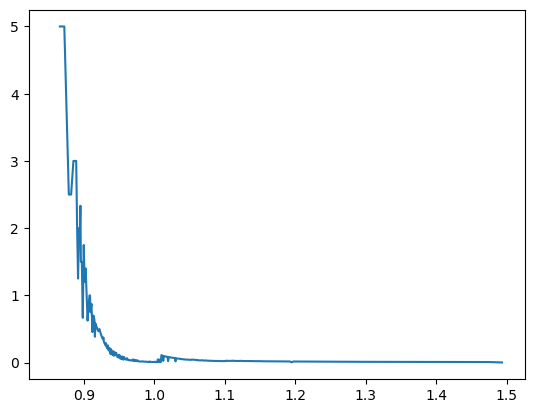

In [146]:
plt.plot(call['M'], (call['ask'] - call['bid'])/call['bid'])

,M,diff,last_price,bs_price
24,1.493517,0.003576,1945.010010,1989.455771
25,1.475079,0.003655,NaN,1939.814381
26,1.457090,0.003737,1948.030029,1890.177243
27,1.439535,0.003823,1425.099976,1840.544958
28,1.422398,0.003914,1732.890015,1790.918292
...,...,...,...,...
410,0.853439,-0.104629,0.250000,0.694328
411,0.841418,-0.113167,0.350000,0.659059
412,0.829732,-0.120936,0.150000,0.625221
413,0.818366,-0.128086,NaN,0.592839


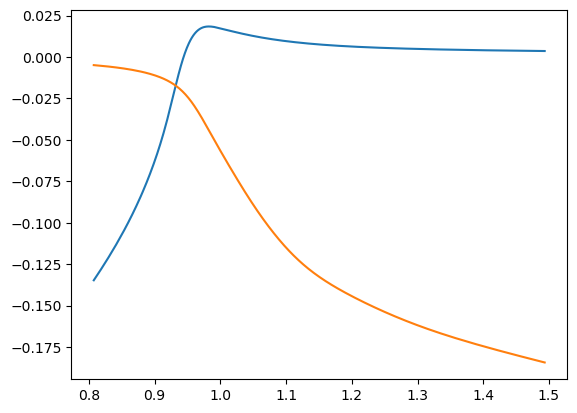

In [189]:
import numpy as np

import pandas as pd

import pandas as pd
import numpy as np
from scipy.stats import norm

def bs_call(S: pd.Series, K: pd.Series, T: pd.Series,
            r: pd.Series, q: pd.Series, sigma: pd.Series) -> pd.Series:
    
    # Initialize output with NaN
    price = pd.Series(data=np.nan, index=S.index, dtype=float)
    
    # Valid input mask: non-null and positive values for sigma and T
    mask = sigma.notna()

    S_valid = S[mask]
    K_valid = K[mask]
    T_valid = T[mask]
    r_valid = r[mask]
    q_valid = q[mask]
    sigma_valid = sigma[mask]
    
    sqrtT = np.sqrt(T_valid)
    
    d1 = (np.log(S_valid / K_valid) + (r_valid - q_valid + 0.5 * sigma_valid**2) * T_valid) / (sigma_valid * sqrtT)
    d2 = d1 - sigma_valid * sqrtT

    # Compute BS call price
    price[mask] = (
        S_valid * np.exp(-q_valid * T_valid) * norm.cdf(d1) -
        K_valid * np.exp(-r_valid * T_valid) * norm.cdf(d2)
    )
    
    return price

def bs_put(S: pd.Series, K: pd.Series, T: pd.Series,
            r: pd.Series, q: pd.Series, sigma: pd.Series) -> pd.Series:
    
    # Initialize output with NaN
    price = pd.Series(data=np.nan, index=S.index, dtype=float)
    
    # Valid input mask: non-null and positive values for sigma and T
    mask = sigma.notna()

    S_valid = S[mask]
    K_valid = K[mask]
    T_valid = T[mask]
    r_valid = r[mask]
    q_valid = q[mask]
    sigma_valid = sigma[mask]
    
    sqrtT = np.sqrt(T_valid)
    
    d1 = (np.log(S_valid / K_valid) + (r_valid - q_valid + 0.5 * sigma_valid**2) * T_valid) / (sigma_valid * sqrtT)
    d2 = d1 - sigma_valid * sqrtT

    # Compute BS call price
    price[mask] = (
        K_valid * np.exp(-r_valid * T_valid) * norm.cdf(-d2) -
        S_valid * np.exp(-q_valid * T_valid) * norm.cdf(-d1) 
    )
    
    return price

call.loc[:, 'bs_price'] = bs_call(call['S'], call['K'], call['T'], call['r'], call['q'], call['thr_iv'])
call.loc[:, 'diff'] = (call['thr_price'] - call['bs_price']) / call['thr_price']

put.loc[:, 'bs_price'] = bs_put(put['S'], put['K'], put['T'], put['r'], put['q'], put['thr_iv'])
put.loc[:, 'diff'] = (put['thr_price'] - put['bs_price']) / put['thr_price']

display(call.loc[:, ['M', 'diff', 'last_price', 'bs_price']])

plt.plot(call['M'], call['diff'])
plt.plot(put['M'], put['diff'])
plt.show()

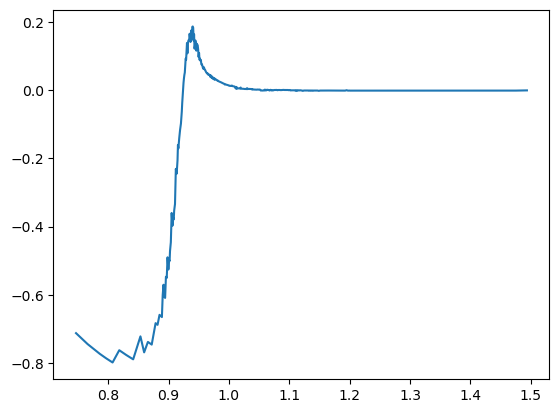

In [170]:
plt.plot(call['M'], (call['mid'] - call['thr_price'])/call['thr_price'])

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


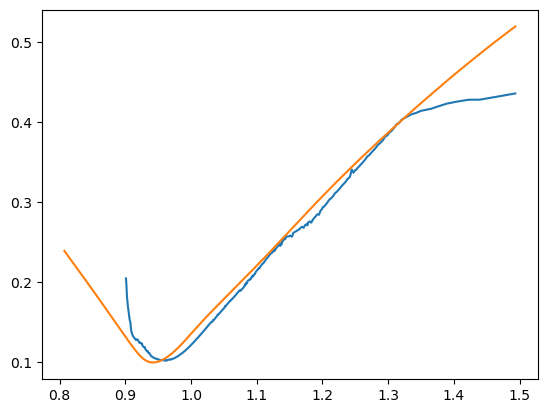

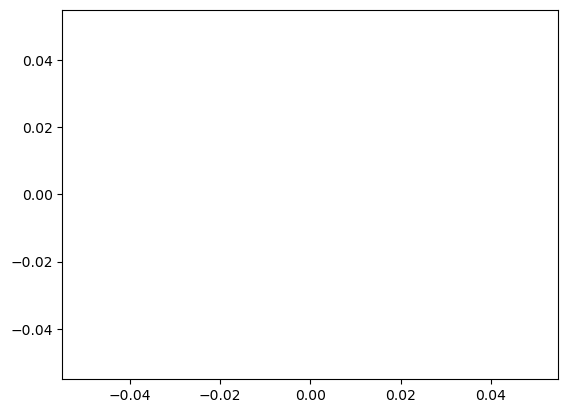

In [204]:
from scipy.optimize import brentq

def find_imvol(mkt: pd.Series, S: pd.Series, K: pd.Series, T: pd.Series, r: pd.Series, q: pd.Series, cp_flag: pd.Series) -> pd.Series:

    def option_price(iv, S, K, T, r, q, cp_flag):
        d1 = (np.log(S / K) + (r - q + 0.5 * iv**2) * T) / (iv * np.sqrt(T))
        d2 = d1 - iv * np.sqrt(T)
        if cp_flag == "C":
            return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif cp_flag == "P":
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        else:
            raise ValueError(f"Invalid cp_flag: {cp_flag}")

    def find_bisection(mkt, S, K, T, r, q, cp_flag, lower=1e-8, upper=3.0):
        def obj(iv):
            return option_price(iv, S, K, T, r, q, cp_flag) - mkt
        
        try:
            return brentq(obj, lower, upper, maxiter=1000, xtol=1e-8)
        except ValueError:
            print('error')
            return np.nan

    return pd.Series([
        find_bisection(m, s, k, t, r_, q_, flag)
        for m, s, k, t, r_, q_, flag in zip(mkt, S, K, T, r, q, cp_flag)
    ])

mkt = call['mid']
call['mid_iv'] = find_imvol(mkt, call['S'], call['K'], call['T'], call['r'], call['q'], call['cp_flag'])

mkt = put['mid']
put['mid_iv'] = find_imvol(mkt, put['S'], put['K'], put['T'], put['r'], put['q'], put['cp_flag'])

plt.plot(call['M'], call['mid_iv'])
plt.plot(call['M'], call['thr_iv'])
plt.show()

plt.plot(put['M'], put['mid_iv'])
# plt.plot(put['M'], put['thr_iv'])
plt.show()

In [199]:
call['mid_iv']

24     0.436076
25     0.433460
26     0.430843
27     0.428304
28     0.428225
         ...   
410         NaN
411         NaN
412         NaN
413         NaN
414         NaN
Name: mid_iv, Length: 391, dtype: float64

In [156]:
put.tail(20)

,ticker,K,bid,ask,last_price,iv,volume,open_interest,delta,gamma,...,thr_price,cp_flag,S,M,mid,r,q,intrinsic_value,bs_price,diff
818,SPXW 1/31/25 P6710,6710,693.900024,712.299988,743.760010,0.133353,NaN,1,-1.0,0.003365,...,703.455255,P,5974.07,0.890323,703.100006,0.045979,0.010253,735.93,710.063810,-0.009904
819,SPXW 1/31/25 P6720,6720,703.700012,721.000000,762.630005,NaN,NaN,17,-1.0,0.000000,...,713.403496,P,5974.07,0.888999,712.350006,0.045979,0.010253,745.93,NaN,NaN
820,SPXW 1/31/25 P6725,6725,709.299988,727.200012,NaN,NaN,NaN,0,-1.0,0.000000,...,718.377655,P,5974.07,0.888338,718.250000,0.045979,0.010253,750.93,NaN,NaN
821,SPXW 1/31/25 P6730,6730,713.599976,731.799988,681.520020,0.118373,NaN,1,-1.0,0.001212,...,723.351837,P,5974.07,0.887678,722.699982,0.045979,0.010253,755.93,729.636246,-0.009598
822,SPXW 1/31/25 P6740,6740,724.400024,742.099976,688.840027,0.146870,NaN,2,-1.0,0.004411,...,733.300265,P,5974.07,0.886361,733.250000,0.045979,0.010253,765.93,740.229336,-0.009518
823,SPXW 1/31/25 P6750,6750,733.500000,750.799988,792.010010,NaN,NaN,16,-1.0,0.000000,...,743.248771,P,5974.07,0.885047,742.149994,0.045979,0.010253,775.93,NaN,NaN
824,SPXW 1/31/25 P6775,6775,758.299988,776.500000,NaN,NaN,NaN,0,-1.0,0.000000,...,768.120326,P,5974.07,0.881782,767.399994,0.045979,0.010253,800.93,NaN,NaN
825,SPXW 1/31/25 P6800,6800,784.000000,801.700012,NaN,NaN,NaN,0,-1.0,0.000000,...,792.992224,P,5974.07,0.878540,792.850006,0.045979,0.010253,825.93,NaN,NaN
826,SPXW 1/31/25 P6850,6850,832.799988,851.400024,NaN,NaN,NaN,0,-1.0,0.000000,...,842.736828,P,5974.07,0.872127,842.100006,0.045979,0.010253,875.93,NaN,NaN
827,SPXW 1/31/25 P6900,6900,882.500000,901.099976,1350.760010,NaN,NaN,2,-1.0,0.000000,...,892.482300,P,5974.07,0.865807,891.799988,0.045979,0.010253,925.93,NaN,NaN


In [153]:
call.tail(20)

,ticker,K,bid,ask,last_price,iv,volume,open_interest,delta,gamma,...,thr_price,cp_flag,S,M,mid,r,q,intrinsic_value,bs_price,diff
399,SPXW 1/31/25 C6710,6710,0.15,0.45,0.54,0.129481,NaN,37,0.003967,0.002823,...,0.751321,C,5974.07,0.890323,0.300,0.045979,0.010253,0.0,0.325175,-0.083915
400,SPXW 1/31/25 C6720,6720,0.10,0.40,0.37,0.128632,NaN,76,0.003355,0.002459,...,0.746360,C,5974.07,0.888999,0.250,0.045979,0.010253,0.0,0.272059,-0.088236
401,SPXW 1/31/25 C6725,6725,0.10,0.40,NaN,0.129356,NaN,0,0.003357,0.002438,...,0.743918,C,5974.07,0.888338,0.250,0.045979,0.010253,0.0,0.271505,-0.086022
402,SPXW 1/31/25 C6730,6730,0.10,0.40,NaN,0.130062,NaN,0,0.003328,0.002406,...,0.741499,C,5974.07,0.887678,0.250,0.045979,0.010253,0.0,0.270607,-0.082427
403,SPXW 1/31/25 C6740,6740,0.10,0.40,4.10,0.131644,NaN,80,0.003291,0.002355,...,0.736724,C,5974.07,0.886361,0.250,0.045979,0.010253,0.0,0.272401,-0.089603
404,SPXW 1/31/25 C6750,6750,0.10,0.40,0.27,0.133177,1.0,63,0.003252,0.002309,...,0.732028,C,5974.07,0.885047,0.250,0.045979,0.010253,0.0,0.273237,-0.092948
405,SPXW 1/31/25 C6775,6775,0.10,0.35,NaN,0.135435,NaN,0,0.002912,0.002049,...,0.720577,C,5974.07,0.881782,0.225,0.045979,0.010253,0.0,0.245339,-0.090395
406,SPXW 1/31/25 C6800,6800,0.10,0.35,0.33,0.139215,NaN,156,0.002849,0.001950,...,0.709469,C,5974.07,0.878540,0.225,0.045979,0.010253,0.0,0.247558,-0.100260
407,SPXW 1/31/25 C6850,6850,0.05,0.30,0.20,0.143122,NaN,11,0.002196,0.001504,...,0.688061,C,5974.07,0.872127,0.175,0.045979,0.010253,0.0,0.194367,-0.110670
408,SPXW 1/31/25 C6900,6900,0.05,0.30,0.30,0.150222,NaN,133,0.002101,0.001376,...,0.667521,C,5974.07,0.865807,0.175,0.045979,0.010253,0.0,0.195402,-0.116584


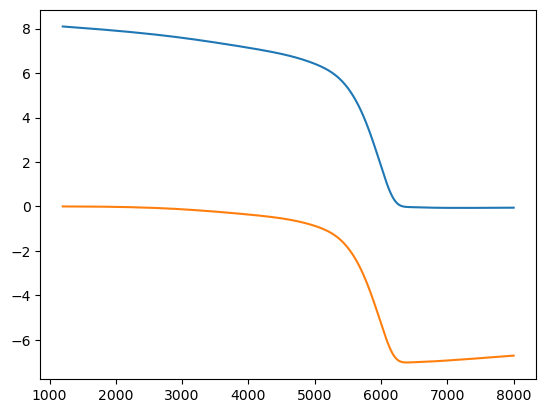

In [98]:
plt.plot(call['K'], call['bs_diff'])
plt.plot(put['K'], put['bs_diff'])

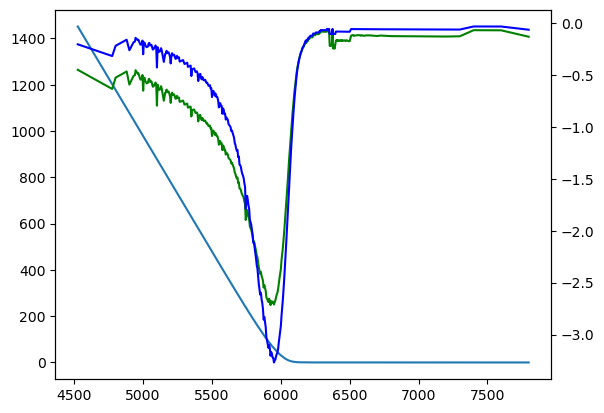

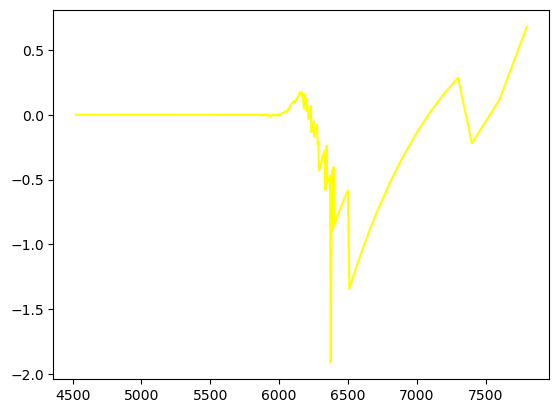

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

df1 = pd.read_excel("20241231.xlsx", engine="openpyxl")
df2 = pd.read_excel("20250131.xlsx", engine="openpyxl")

def BlackScholes(cp_flag, S, K, T, r, q, sigma, xtype):
    if xtype.lower() == "euro":
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)    
        if cp_flag == "C":
            price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif cp_flag == "P":
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return price

def format_df(df):
    df['ref_date'] = pd.to_datetime(df['ref_date'], format='%m/%d/%y')
    df['exp_date'] = pd.to_datetime(df['exp_date'], format='%m/%d/%y')
    
    df['S'] = pd.to_numeric(df['S'], errors='coerce')
    df['K'] = pd.to_numeric(df['K'], errors='coerce')
    df['M'] = pd.to_numeric(df['M'], errors='coerce')
    df['T'] = pd.to_numeric(df['T'], errors='coerce')
    df['r'] = pd.to_numeric(df['r'], errors='coerce')
    df['q'] = pd.to_numeric(df['q'], errors='coerce')
    df['bid'] = pd.to_numeric(df['bid'], errors='coerce')
    df['ask'] = pd.to_numeric(df['ask'], errors='coerce')
    df['last_price'] = pd.to_numeric(df['last_price'], errors='coerce')
    df['iv'] = pd.to_numeric(df['iv'], errors='coerce')
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
    df['open_interest'] = pd.to_numeric(df['open_interest'], errors='coerce')
    df['delta'] = pd.to_numeric(df['delta'], errors='coerce')
    df['theta'] = pd.to_numeric(df['theta'], errors='coerce')
    df['vega'] = pd.to_numeric(df['vega'], errors='coerce')
    df['rho'] = pd.to_numeric(df['rho'], errors='coerce')
    df['thr_iv'] = pd.to_numeric(df['thr_iv'], errors='coerce')
    df['thr_price'] = pd.to_numeric(df['thr_price'], errors='coerce')
    return df

df1 = format_df(df1)
df2 = format_df(df2)

call = df1[df1['cp_flag'] == "C"]
call = call[(call['last_price'] > 0) & (call['iv'] > 0)]
price_iv = []
price_thriv = []
for idx, row in call.iterrows():
    cp_flag, S, K, T, r, q, sigma, xtype = row[['cp_flag', 'S', 'K', 'T', 'r', 'q', 'iv', 'xtype']].values
    price_iv.append(BlackScholes(cp_flag, S, K, T, r, q, sigma, xtype))
    cp_flag, S, K, T, r, q, sigma, xtype = row[['cp_flag', 'S', 'K', 'T', 'r', 'q', 'thr_iv', 'xtype']].values
    price_thriv.append(BlackScholes(cp_flag, S, K, T, r, q, sigma, xtype))
    
call.loc[:, 'price_iv'] = price_iv
call.loc[:, 'price_thriv'] = price_thriv
call.loc[:, 'mid'] = (call['bid'] + call['ask'])/2

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(call['K'], call['mid'])
# ax1.plot(call['K'], call['last_price'] - call['mid'], color = 'blue')
# ax1.plot(call['K'], call['last_price'] - call['price_iv'], color = 'red')
# ax1.plot(call['K'], call['last_price'] - call['price_thriv'], color = 'black')
# --> mid is very similar to price based on market implied volatility
ax2.plot(call['K'], call['mid'] - call['price_iv'], color = 'green')
# ax2.plot(call['K'], call['mid'] - call['price_thriv'], color = 'yellow')
# ax2.plot(call['K'], call['mid'] - call['thr_price'], color = 'red')
ax2.plot(call['K'], call['theta'], color = 'blue')
# diff means theta price_iv (implied vol) t-1, mid t
plt.show()

plt.plot(call['K'], (call['mid'] - call['price_thriv']) / call['mid'], color = 'yellow')
plt.show()

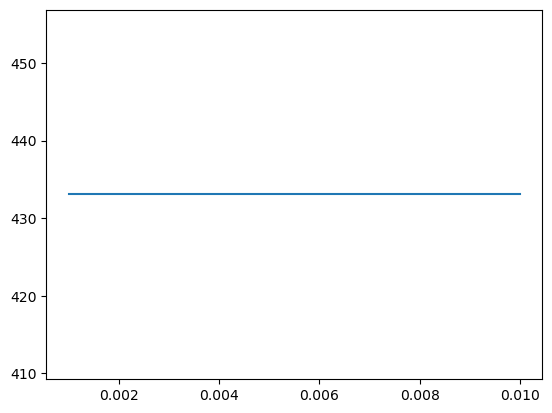

In [15]:
S0 = 5974.07
K = 5545
bid = 426.8999939	
ask = 441.7000122
tau = 0.021721905124302384	
r = 0.04597907	
q = 0.01202712

temp = []
sigma_grid = np.linspace(0.001, 0.01, 1000)
for sigma in sigma_grid:
    temp.append(BlackScholes('C', S0, K, tau, r, q, sigma, 'Euro'))

plt.plot(sigma_grid, temp)
plt.show()

In [16]:
print(temp[-1])

433.04478705605015


In [12]:
S0 = 5974.07
K = 5545
bid = 426.8999939	
ask = 441.7000122
tau = 0.021721905124302384	
r = 0.04597907	
q = 0.01202712
lowerbound=0
upperbound=3.0
max_iter=1000
tol=1e-6

def bs_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1) -
                  K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

for _ in range(max_iter):
    print("upperbound", upperbound)
    print("lowerbound", lowerbound)
    mid = (upperbound + lowerbound) / 2
    print("mid", mid)
    price = bs_call(S, K, T, r, q, mid)
    print("price", price)
    diff = price - bid
    print("diff", diff)

    if abs(diff) < tol:
        print(mid)
    
    if diff > 0:
        upperbound = mid
    else:
        lowerbound = mid
        
raise ValueError("Implied volatility not found within max_iter")

upperbound 3.0
lowerbound 0
mid 1.5
price 752.0951984473163
diff 325.1952045473163
upperbound 1.5
lowerbound 0
mid 0.75
price 526.7763943681693
diff 99.87640046816932
upperbound 0.75
lowerbound 0
mid 0.375
price 445.712188285931
diff 18.81219438593098
upperbound 0.375
lowerbound 0
mid 0.1875
price 433.2006465745544
diff 6.300652674554385
upperbound 0.1875
lowerbound 0
mid 0.09375
price 433.0447874069705
diff 6.144793506970473
upperbound 0.09375
lowerbound 0
mid 0.046875
price 433.04478705605015
diff 6.144793156050127
upperbound 0.046875
lowerbound 0
mid 0.0234375
price 433.04478705605015
diff 6.144793156050127
upperbound 0.0234375
lowerbound 0
mid 0.01171875
price 433.04478705605015
diff 6.144793156050127
upperbound 0.01171875
lowerbound 0
mid 0.005859375
price 433.04478705605015
diff 6.144793156050127
upperbound 0.005859375
lowerbound 0
mid 0.0029296875
price 433.04478705605015
diff 6.144793156050127
upperbound 0.0029296875
lowerbound 0
mid 0.00146484375
price 433.04478705605015
diff 

ValueError: Implied volatility not found within max_iter

Mid price is compatible with theoretical implied volatility

market implied volatility lagged one time before, generating theta between mid and price_iv

I use theoretical implied volatiltiy as our volatility and mid price, not last traded price

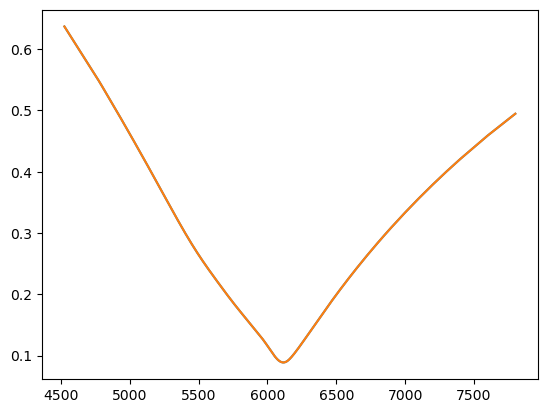

In [180]:
from scipy.optimize import brentq, newton
import numpy as np
import warnings
import matplotlib.pyplot as plt

def imvol(market_price, S, K, T, r, q, cp_flag='C', xtype='Euro'):
    def objective_function(sigma):
        return BlackScholes(cp_flag, S, K, T, r, q, sigma, xtype) - market_price

    def vega(S, K, T, r, q, sigma):
        from scipy.stats import norm
        if sigma <= 0 or T <= 0:
            return 0.0
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

    sigma_lower = 1e-10
    sigma_upper = 3.0

    f_lower = objective_function(sigma_lower)
    f_upper = objective_function(sigma_upper)

    if f_lower * f_upper > 0:
        # message = (
        #     f"[Warning] brentq 실패 (부호 변화 없음): "
        #     f"f({sigma_lower:.1e}) = {f_lower:.4f}, f({sigma_upper:.1f}) = {f_upper:.4f} "
        #     f":: (S={S}, K={K}, T={T:.4f}, price={market_price:.4f})"
        # )
        # warnings.warn(message)
        return np.nan

    try:
        return brentq(objective_function, sigma_lower, sigma_upper, maxiter=1000, xtol=1e-8)
    except ValueError as e:
        # warnings.warn(f"brentq 실패: {e} — Newton-Raphson fallback 시도")

        sigma0 = 0.2
        vega0 = vega(S, K, T, r, q, sigma0)

        # if vega0 < 1e-8:
        #     warnings.warn(f"Vega 너무 작음 (vega={vega0:.2e}), IV 계산 중단 :: (S={S}, K={K}, T={T:.4f})")
        #     return np.nan

        try:
            return newton(
                objective_function,
                x0=sigma0,
                fprime=lambda s: vega(S, K, T, r, q, s),
                maxiter=100,
                tol=1e-8
            )
        except Exception as e2:
            # warnings.warn(f"Newton-Raphson 실패: {e2} :: (S={S}, K={K}, T={T:.4f})")
            return np.nan

result = []
bid_iv = []
for idx, row in call.iterrows():
    price, S, K, T, r, q = row[['price_thriv', 'S', 'K', 'T', 'r', 'q']].values
    iv = imvol(price, S, K, T, r, q)
    result.append(iv)
    
plt.plot(call['K'], result)
plt.plot(call['K'], call['thr_iv'])
plt.show()

Text(0.5, 1.0, 'Bid, Ask, Mid IV with S0 = 5974.07')

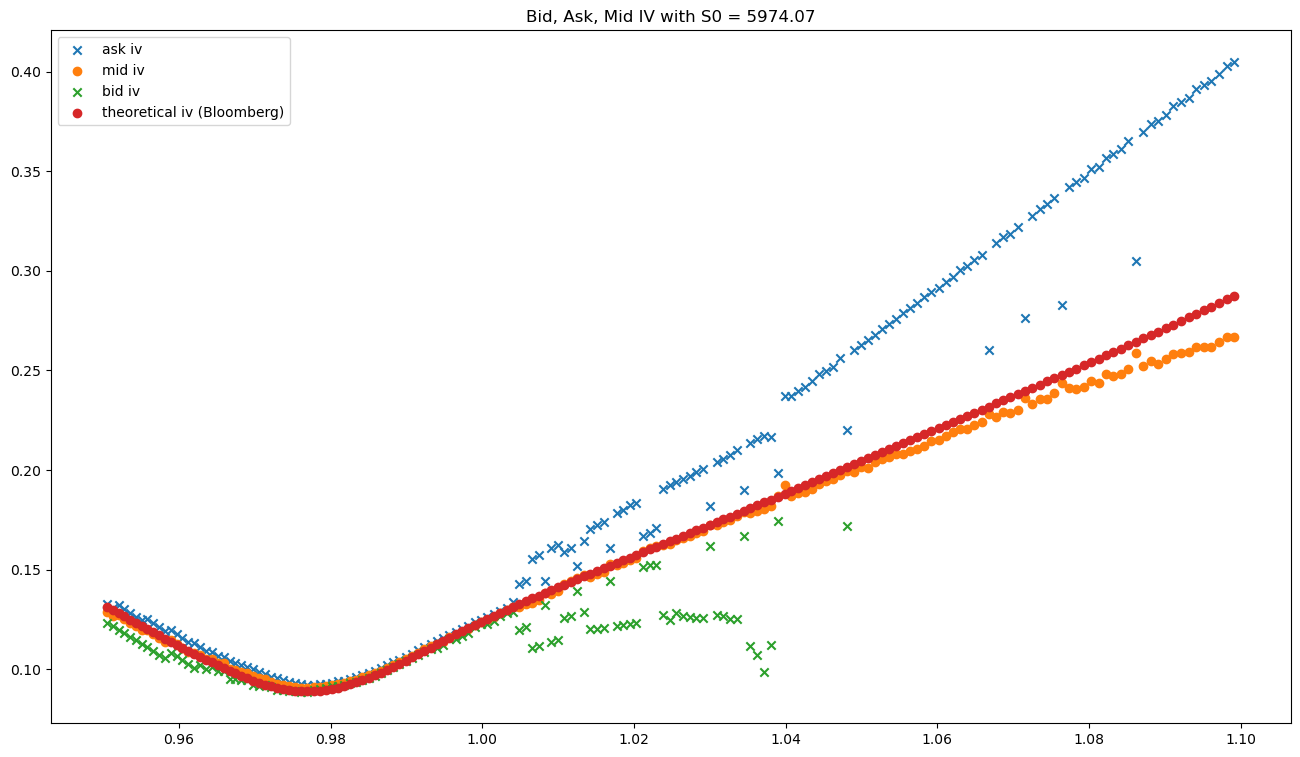

In [187]:
call_except = call[(call['M'] > 0.95) * (call['M'] <1.1)]

bid_iv = []
ask_iv = []
mid_iv = []
for idx, row in call_except.iterrows():
    bid, ask, mid, S, K, T, r, q = row[['bid', 'ask', 'mid', 'S', 'K', 'T', 'r', 'q']].values
    bid_iv.append(imvol(bid, S, K, T, r, q))
    ask_iv.append(imvol(ask, S, K, T, r, q))
    mid_iv.append(imvol(mid, S, K, T, r, q))
    
call_except.loc[:, ['bid_iv']] = bid_iv
call_except.loc[:, ['ask_iv']] = ask_iv
call_except.loc[:, ['mid_iv']] = mid_iv

plt.figure(figsize=(16, 9))
plt.scatter(call_except['M'], call_except['ask_iv'], label = "ask iv", marker='x')
plt.scatter(call_except['M'], call_except['mid_iv'], label = 'mid iv')
plt.scatter(call_except['M'], call_except['bid_iv'], label = 'bid iv', marker='x')
plt.scatter(call_except['M'], call_except['thr_iv'], label = 'theoretical iv (Bloomberg)')
plt.legend()
# plt.axvline(5974.07, linestyle='--')
plt.title("Bid, Ask, Mid IV with S0 = 5974.07")

In [190]:
call_except[(call_except['M'] > 1.02) * (call_except['M'] <1.04)][['S','K','M','bid','ask','bid_iv','ask_iv']]

,S,K,M,bid,ask,bid_iv,ask_iv
311,5974.07,5745,1.039873,232.300003,246.199997,NaN,0.237058
312,5974.07,5750,1.038969,232.500000,235.500000,0.174370,0.198247
313,5974.07,5755,1.038066,223.600006,233.899994,0.111982,0.216651
314,5974.07,5760,1.037165,218.399994,229.600006,0.098588,0.217132
315,5974.07,5765,1.036265,213.600006,225.000000,0.107105,0.215762
316,5974.07,5770,1.035367,208.800003,220.300003,0.111583,0.213763
317,5974.07,5775,1.034471,208.500000,211.800003,0.167062,0.189845
318,5974.07,5780,1.033576,199.699997,211.000000,0.124977,0.210116
319,5974.07,5785,1.032683,194.899994,206.199997,0.125199,0.207417
320,5974.07,5790,1.031791,190.199997,201.600006,0.126421,0.205694


In [26]:
S0 = 5974.07
K = 5545
bid = 426.8999939	
ask = 441.7000122
tau = 0.021721905124302384	
r = 0.04597907	
q = 0.01202712

lowerbound=0
upperbound=3.0
max_iter=1000
tol=1e-6

def bs_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1) -
                  K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

for _ in range(max_iter):
    print("upperbound", upperbound)
    print("lowerbound", lowerbound)
    mid = (upperbound + lowerbound) / 2
    print("mid", mid)
    price = bs_call(S0, K, T, r, q, mid)
    print("price", price)
    diff = price - bid
    print("diff", diff)

    if abs(diff) < tol:
        print("!!result!!", mid)
        break
    
    if diff > 0:
        upperbound = mid
    else:
        lowerbound = mid
        
if diff > tol:
    raise ValueError("Implied volatility not found within max_iter")
# ask: !!result!! 0.3422658294439316

upperbound 3.0
lowerbound 0
mid 1.5
price 752.0951984473163
diff 325.1952045473163
upperbound 1.5
lowerbound 0
mid 0.75
price 526.7763943681693
diff 99.87640046816932
upperbound 0.75
lowerbound 0
mid 0.375
price 445.712188285931
diff 18.81219438593098
upperbound 0.375
lowerbound 0
mid 0.1875
price 433.2006465745544
diff 6.300652674554385
upperbound 0.1875
lowerbound 0
mid 0.09375
price 433.0447874069705
diff 6.144793506970473
upperbound 0.09375
lowerbound 0
mid 0.046875
price 433.04478705605015
diff 6.144793156050127
upperbound 0.046875
lowerbound 0
mid 0.0234375
price 433.04478705605015
diff 6.144793156050127
upperbound 0.0234375
lowerbound 0
mid 0.01171875
price 433.04478705605015
diff 6.144793156050127
upperbound 0.01171875
lowerbound 0
mid 0.005859375
price 433.04478705605015
diff 6.144793156050127
upperbound 0.005859375
lowerbound 0
mid 0.0029296875
price 433.04478705605015
diff 6.144793156050127
upperbound 0.0029296875
lowerbound 0
mid 0.00146484375
price 433.04478705605015
diff 

ValueError: Implied volatility not found within max_iter

In [43]:
def bs_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1) -
                  K * np.exp(-r * T) * norm.cdf(d2))
    print(d1, norm.cdf(d1), S * np.exp(-q * T))
    print(d2, norm.cdf(d2), )
    return call_price

bs_call(S0, K, T, r, q, 0.000001)

510703.7200133978 1.0 5972.509466361071
510703.7200132504 1.0


433.04478705605015

In [ ]:
S0 * np.exp()

433.04478705605015
434.30000305
bid 426.8999939
ask 441.7000122
lower bound of call option price 433.04478705605015


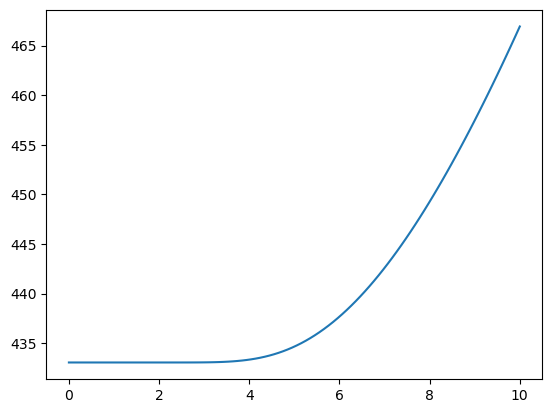

In [48]:
def bs_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1) -
                  K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

a = [bs_call(S0, K, T, r, q, sigma) for sigma in np.linspace(0.00001, 0.5, 100)]
plt.plot(np.linspace(0.00001, 10, 100), a)
print(a[0])
bid = 426.8999939
ask = 441.7000122
print((bid + ask) / 2)
print("bid", bid)
print("ask", ask)
print("lower bound of call option price", max(S0 * np.exp(-q * T) - K * np.exp(-r * T), 0))

In [30]:
bid = 426.899993
bs_call(S0, K, T, r, q, 0.20226)

433.3627089397005

In [158]:
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1) -
                  K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# Parameters
S = 5974.07
K = 4525
T = 0.02172
r = 0.046
q = 0.01203
market_price = 1439.6

def objective(sigma):
    return black_scholes_call(S, K, T, r, q, sigma) - market_price

# Solve for implied volatility
iv = brentq(objective, 1e-6, 3.0, xtol=1e-10)
print(f"Implied Volatility: {iv:.6f}")

ValueError: f(a) and f(b) must have different signs

In [ ]:
BlackScholes("C", 5974.07, 4525)

⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 12.4266, f(1.0) = 21.0973
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 2.1761, f(1.0) = 23.9017
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 2.5011, f(1.0) = 26.1209
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8710, f(1.0) = 37.5007
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8760, f(1.0) = 37.9771
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8809, f(1.0) = 38.4594
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 2.4009, f(1.0) = 34.9484
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8309, f(1.0) = 43.5160
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8359, f(1.0) = 44.0661
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8408, f(1.0) = 44.6226
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.8458, f(1.0) = 45.1856
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.7608, f(1.0) = 46.8141
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.7658, f(1.0) = 47.4036
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 7.7808, f(1.0) = 49.2126
⚠️ br

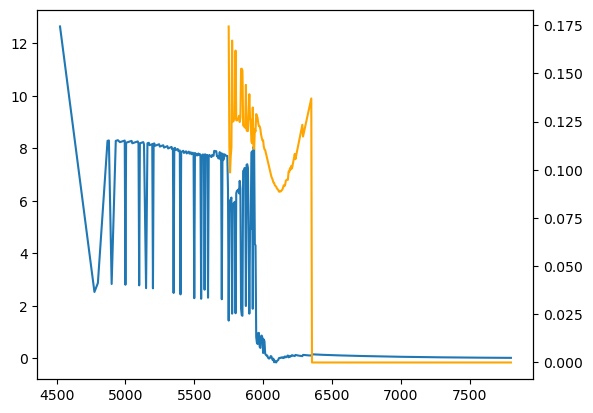

In [143]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(call['K'], call['price_thriv'] - call['bid'])
bid_iv = []
for idx, row in call.iterrows():
    price, S, K, T, r, q = row[['bid', 'S', 'K', 'T', 'r', 'q']].values
    price = round(price, 2)
    iv = imvol(price, S, K, T, r, q)
    bid_iv.append(iv)
ax2.plot(call['K'], bid_iv, color='orange')

In [135]:
call['price_thriv'].tail()

492    0.041786
493    0.035731
494    0.030504
496    0.022133
497    0.015971
Name: price_thriv, dtype: float64

In [136]:
call['mid'].tail()

492    0.050
493    0.050
494    0.025
496    0.025
497    0.050
Name: mid, dtype: float64

⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4266, f(1.0) = 9.0973
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.1761, f(1.0) = 21.9017
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.3511, f(1.0) = 23.9709
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4210, f(1.0) = 30.0507
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4260, f(1.0) = 30.5271
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4309, f(1.0) = 31.0094
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.2509, f(1.0) = 32.7984
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.3809, f(1.0) = 36.0660
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.3859, f(1.0) = 36.6161
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.3908, f(1.0) = 37.1726
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4458, f(1.0) = 37.7856
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4108, f(1.0) = 39.4641
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.4158, f(1.0) = 40.0536
⚠️ brentq 실패 가능성: 함수값의 부호 변화 없음.
f(1.0e-10) = 0.3308, f(1.0) = 41.7626
⚠️ bren

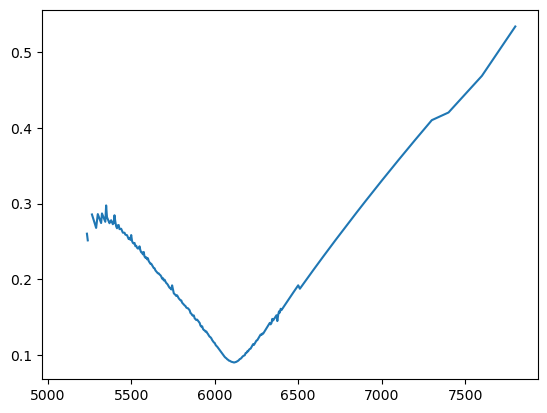

In [137]:
bid_iv = []
for idx, row in call.iterrows():
    price, S, K, T, r, q = row[['mid', 'S', 'K', 'T', 'r', 'q']].values
    price = round(price, 2)
    iv = imvol(price, S, K, T, r, q)
    bid_iv.append(iv)
plt.plot(call['K'], bid_iv)

In [133]:
call['bid']

87     1439.599976
117    1200.099976
122    1174.800049
136    1099.500000
137    1094.500000
          ...     
492       0.000000
493       0.000000
494       0.000000
496       0.000000
497       0.000000
Name: bid, Length: 329, dtype: float64

In [125]:
call['price_thriv']

87     1452.236017
117    1202.625635
122    1177.665940
136    1107.779974
137    1102.788240
          ...     
492       0.041786
493       0.035731
494       0.030504
496       0.022133
497       0.015971
Name: price_thriv, Length: 329, dtype: float64

In [106]:
import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol, q):
    d1 = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return np.exp(-q * T) * S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, q):
    MAX_ITERATIONS = 5000
    PRECISION = 1.0e-7
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma, q)
        vega = bs_vega(S, K, T, r, sigma, q)
        diff = target_value - price
        if abs(diff) < PRECISION:
            return sigma
        sigma += diff / vega
    return np.nan

bid_iv = []
ask_iv = []
mid_iv = []
for idx, row in call.iterrows():
    cp_flag, S, bid, ask, K, T, r, q, sigma, xtype = row[['cp_flag', 'S', 'bid', 'ask', 'K', 'T', 'r', 'q', 'iv', 'xtype']].values
    mid = (bid + ask) / 2
    bid_iv.append(find_vol(bid, S, K, T, r, q))
    # ask_iv.append(implied_volatility(ask, S, K, T, r, q))
    # mid_iv.append(implied_volatility(mid, S, K, T, r, q))
    
plt.figure(figsize=(15, 6))
plt.plot(call['K'], bid_iv, color='blue')
# plt.plot(call['K'], ask_iv, color='red')
# plt.scatter(call['K'], mid_iv, marker='x', color='green')
# plt.scatter(call['K'], call['thr_iv'])

/var/folders/8w/ymp44q_55w153j7pl6ly_0y00000gn/T/ipykernel_33663/3354445238.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  sigma += diff / vega
/var/folders/8w/ymp44q_55w153j7pl6ly_0y00000gn/T/ipykernel_33663/3354445238.py:6: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
/var/folders/8w/ymp44q_55w153j7pl6ly_0y00000gn/T/ipykernel_33663/3354445238.py:11: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/8w/ymp44q_55w153j7pl6ly_0y00000gn/T/ipykernel_33663/3354445238.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  sigma += diff / vega
/var/folders/8w/ymp44q_55w153j7pl6ly_0y00000gn/T/ipykernel_33663/3354445238.py:6: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
/var/folders/8w/ymp44q_55w153j7pl6l

KeyboardInterrupt: 

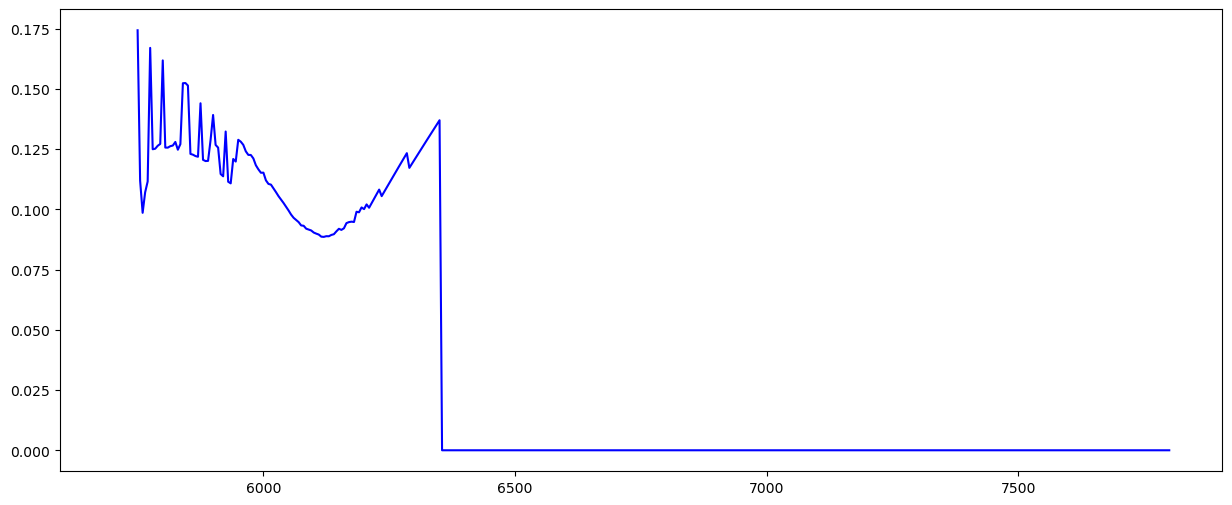

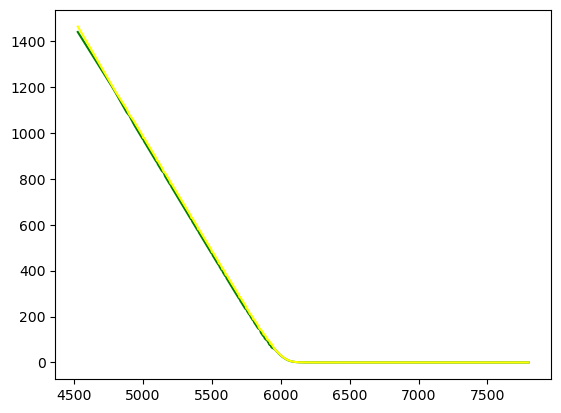

In [92]:
plt.plot(call['K'], call['bid'], color='green')
plt.plot(call['K'], call['ask'], color='yellow')

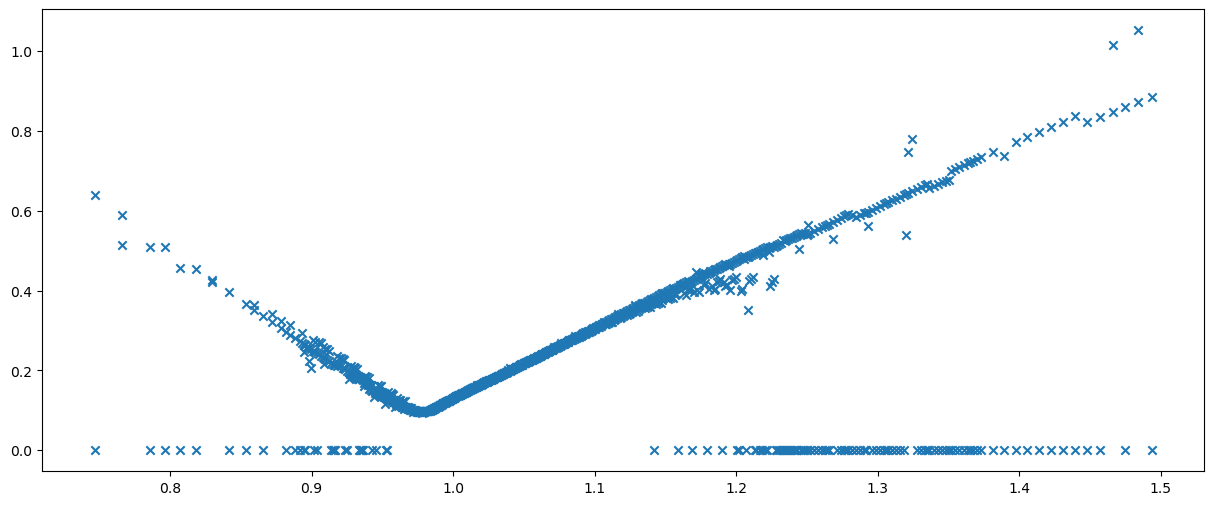

In [6]:
import matplotlib.pyplot as plt
df = df1[(df1['M'] < 1.5) & (df1['M'] > 0.7)]

plt.scatter(df['M'], df['iv'], marker='x')

In [70]:
call

,ref_date,uticker,exp_date,cp_flag,K,ticker,S,M,T,r,...,theta,vega,rho,day_ex,xtype,thr_iv,thr_price,price_iv,price_thriv,mid
87,2024-12-23,SPXW,2024-12-31,C,4525,SPXW 12/31/24 C4525,5974.07,1.320236,0.021722,0.045979,...,-0.204883,0.003194,0.009819,7.928495,Euro,0.637067,1451.702085,1452.050434,1452.236017,1451.599976
117,2024-12-23,SPXW,2024-12-31,C,4775,SPXW 12/31/24 C4775,5974.07,1.251114,0.021722,0.045979,...,-0.317885,0.050972,0.010337,7.928495,Euro,0.548368,1202.031530,1202.734692,1202.625635,1202.099976
122,2024-12-23,SPXW,2024-12-31,C,4800,SPXW 12/31/24 C4800,5974.07,1.244598,0.021722,0.045979,...,-0.219025,0.023066,0.010406,7.928495,Euro,0.538978,1177.065687,1177.475435,1177.665940,1176.950012
136,2024-12-23,SPXW,2024-12-31,C,4870,SPXW 12/31/24 C4870,5974.07,1.226708,0.021722,0.045979,...,-0.168296,0.008762,0.010565,7.928495,Euro,0.512282,1107.162487,1107.424602,1107.779974,1106.950012
137,2024-12-23,SPXW,2024-12-31,C,4875,SPXW 12/31/24 C4875,5974.07,1.225450,0.021722,0.045979,...,-0.164483,0.007449,0.010576,7.928495,Euro,0.510360,1102.169502,1102.420416,1102.788240,1101.950012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,2024-12-23,SPXW,2024-12-31,C,7200,SPXW 12/31/24 C7200,5974.07,0.829732,0.021722,0.045979,...,-0.062448,0.028884,0.000013,7.928495,Euro,0.378983,0.019570,0.179938,0.041786,0.050000
493,2024-12-23,SPXW,2024-12-31,C,7300,SPXW 12/31/24 C7300,5974.07,0.818366,0.021722,0.045979,...,-0.062806,0.027378,0.000012,7.928495,Euro,0.400286,0.016383,0.177610,0.035731,0.050000
494,2024-12-23,SPXW,2024-12-31,C,7400,SPXW 12/31/24 C7400,5974.07,0.807307,0.021722,0.045979,...,-0.033161,0.014949,0.000006,7.928495,Euro,0.420714,0.013697,0.093983,0.030504,0.025000
496,2024-12-23,SPXW,2024-12-31,C,7600,SPXW 12/31/24 C7600,5974.07,0.786062,0.021722,0.045979,...,-0.033496,0.013642,0.000006,7.928495,Euro,0.459149,0.009535,0.095041,0.022133,0.025000


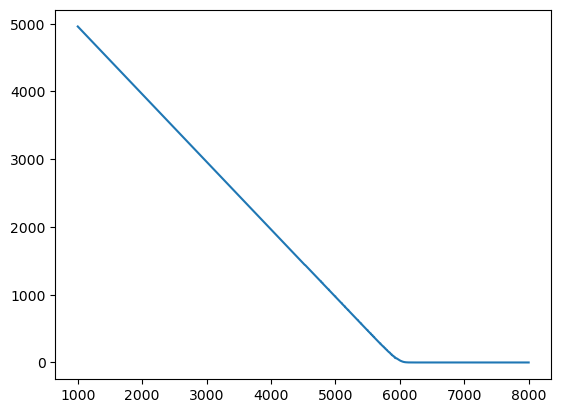

In [72]:
call = df1[df1['cp_flag'] == "C"]
plt.plot(call['K'], call['bid'])